# ACE Exploration: Peptide Feature Similarities Exploration

### Dhuvarakesh Karthikeyan and Jin Seok (Andy) Lee

In [1]:
#Import Dependencies

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
from sklearn.model_selection import train_test_split

import difflib
import Levenshtein as levenshtein
from collections import Counter
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import mhcflurry
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
torch.cuda.is_available()

True

### Load in the Data

In [3]:
### For one of the sequence similarity experiments, we remove the following epitopes from the training data.

mage3_epitopes = [
"ESDPIVAQY",
"EVDPIGHLY",
"EVDPIGHVY",
"EVDPIRHYY",
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
]

In [4]:
### Get the raw data of paired TCR:pMHC Data
raw_df = pd.read_csv("../data/post_processing_all_data.csv")
data_df = raw_df[["CDR3b", "Epitope", 'Allele', 'Condition', 'Dataset.Origin']]
data_df = data_df[data_df['Dataset.Origin'] != 'MIRA']

### Filter out the SARS-Cov2 data

# Define a regular expression pattern to match flexible combinations of "Sars-cov2"
pattern = re.compile(r'sars[\W_]*cov[\W_]*[12]', re.IGNORECASE)
# Take out the SARS-Cov2 data
holdout_df = data_df[data_df['Condition'].str.contains(pattern, na=False)]
data_df = data_df[~data_df['Condition'].str.contains(pattern, na=False)]
data_df = data_df[~data_df['Condition'].str.contains('coronavirus', na=False)]

### Filter out the MAGE3a data
data_df = data_df[~data_df['Epitope'].isin(mage3_epitopes)]
assert set(data_df['Epitope']).intersection(mage3_epitopes) == set()

# Concatenate all of the different Conditions [Disease Contexts]
data_df = data_df.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
data_df['Dataset.Origin'] = [data_df['Dataset.Origin'][i][0] for i in range(len(data_df))]
holdout_df = holdout_df.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
data_df.sort_values(by=['CDR3b', 'Epitope'])

/tmp/ipykernel_10152/4196429394.py:2: DtypeWarning: Columns (0,6,7,8,9,10,11,12,13,15,17,18,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../data/post_processing_all_data.csv")


,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,CAAADEEIGNQPQHF,ATDALMTGY,HLA-A*01:01,"[Hepatitis C virus, HCV]",IEDB
1,CAAAHLDSSNEQYF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
2,CAAALGGGANEQF,GILGFVFTL,HLA-A*02:01,[Influenza A virus],IEDB
3,CAAALGQSRTPGSCFF,GLCTLVAML,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
4,CAAALWTQHF,GILGFVFTL,HLA-A*02:01,[Influenza A virus],IEDB
...,...,...,...,...,...
66876,CYSYNEQFF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
66877,CYTF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
66878,CYTF,YVLDHLIVV,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
66879,CYVGQALYNEQFF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB


In [5]:
# Filter the numbers of CDR3b for counts over 1
cdr3b_counts = data_df['CDR3b'].value_counts()
cdr3b_counts = cdr3b_counts[cdr3b_counts > 1]
data_df2 = data_df[data_df['CDR3b'].isin(cdr3b_counts.index)]
data_df2.sort_values(by=['CDR3b', 'Epitope'])
data_df2.reset_index(inplace=True, drop=True)
data_df2

,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,CAAGEMFGLGETQYF,AVFDRKSDAK,HLA-A*11:01,[EBV],VDJdb
1,CAAGEMFGLGETQYF,KLGGALQAK,HLA-A*03:01,[CMV],VDJdb
2,CAAGGGGTEKLFF,GLCTLVAML,HLA-A*02:01,[EBV],VDJdb
3,CAAGGGGTEKLFF,IVTDFSVIK,HLA-A*11:01,"[EBV, EBV]",VDJdb
4,CAAGGGGTEKLFF,KLGGALQAK,HLA-A*03:01,"[CMV, CMV]",VDJdb
...,...,...,...,...,...
10531,CYGYTF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
10532,CYNEQFF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
10533,CYNEQFF,YVLDHLIVV,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
10534,CYTF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB


In [6]:
negative_injection = pd.read_csv('../data/negative_epitopes.csv')
negative_injection = negative_injection[['Epitope - Name', 'Epitope - Source Organism']]
negative_injection.columns = ['Epitope', 'Condition']
# Use the SARS pattern from the beginning
negative_injection = negative_injection[~negative_injection['Condition'].str.contains(pattern, na=False)]
negative_injection = negative_injection[~negative_injection['Condition'].str.contains('coronavirus', na=False)]
# Assign Arbitrary Allele and CDR3b
negative_injection['Allele'] = ['HLA-ALL3L3']* len(negative_injection)
negative_injection['CDR3b'] = ['AAAAAAAAAAAA']* len(negative_injection)
negative_injection['Dataset.Origin'] = ['Negative']* len(negative_injection)
# Filter for reasonable epitope length
negative_injection['Epitope_Length'] = [len(epi) for epi in negative_injection['Epitope']]
negative_injection = negative_injection[negative_injection['Epitope_Length'] <= 15]
negative_injection = negative_injection.drop(['Epitope_Length'], axis=1, inplace=False)
# Subset
negative_injection = negative_injection[['CDR3b', 'Epitope', 'Allele', 'Condition', 'Dataset.Origin']]
negatigve_injection = negative_injection.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
negative_injection = negative_injection[~negative_injection['Epitope'].isin(mage3_epitopes)]

negative_injection

,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,AAAAAAAAAAAA,AAAAAIFVI,HLA-ALL3L3,Homo sapiens,Negative
1,AAAAAAAAAAAA,AAAIFMTATPPGTAD,HLA-ALL3L3,dengue virus type 3,Negative
2,AAAAAAAAAAAA,AAALALHFL,HLA-ALL3L3,Human herpesvirus 5 strain AD169,Negative
3,AAAAAAAAAAAA,AAALALLASLILGT,HLA-ALL3L3,Human herpesvirus 4 strain B95-8,Negative
4,AAAAAAAAAAAA,AAASKVKANLLSVEE,HLA-ALL3L3,hepatitis C virus genotype 1a,Negative
...,...,...,...,...,...
30286,AAAAAAAAAAAA,WCGPTPSYNKRVF,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30287,AAAAAAAAAAAA,WNSNPPRNNAELD,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30288,AAAAAAAAAAAA,YADLYFEHKNTTP,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30289,AAAAAAAAAAAA,YENPLSVEKPSRS,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative


In [7]:
# Do this to remove the peptides that are too close to positive examples
def k_edit_distance_pairs(list1, list2, k):
    pairs = []
    for string1 in list1:
        for string2 in list2:
            if levenshtein.distance(string1, string2) <= k:
                pairs.append((string1, string2))
    
    return pairs

k_edit_paired_peptides = k_edit_distance_pairs(data_df2['Epitope'], negative_injection['Epitope'], 2)

In [8]:
_,  k_negative_peptides = zip(*k_edit_paired_peptides)
negative_injection = negative_injection[~negative_injection['Epitope'].isin(list(k_negative_peptides))]
data_df3 = pd.concat([data_df2, negative_injection])
data_df3.sample(frac=1)

,CDR3b,Epitope,Allele,Condition,Dataset.Origin
11588,AAAAAAAAAAAA,ALPCLDPAHPLRRFK,HLA-ALL3L3,Human alphaherpesvirus 2,Negative
988,AAAAAAAAAAAA,DEYILRGLL,HLA-ALL3L3,Vaccinia virus,Negative
16139,AAAAAAAAAAAA,ALLQVTLLL,HLA-ALL3L3,NaN,Negative
11771,AAAAAAAAAAAA,CNVATADFNRNDGRL,HLA-ALL3L3,Human alphaherpesvirus 2,Negative
2235,AAAAAAAAAAAA,FYPNLTKYL,HLA-ALL3L3,Hepatitis B virus,Negative
...,...,...,...,...,...
23174,AAAAAAAAAAAA,AVEEVSLRK,HLA-ALL3L3,Homo sapiens,Negative
671,CASRLAGLYTDTQYF,STLPETAVVRR,HLA-A*11:01,[Hepatitis B virus (Human hepatitis B virus)],IEDB
6126,AAAAAAAAAAAA,NSYYWPDIY,HLA-ALL3L3,Vaccinia virus,Negative
2628,AAAAAAAAAAAA,GTHPSSSAGLK,HLA-ALL3L3,Influenza A virus (A/Puerto Rico/8/1934(H1N1)),Negative


### Exploratory Data Analysis & Visualization

In [9]:
##################################################################################
##################### Utils for Sampling #########################################
##################################################################################

def sample_ingroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from the same TCR group.
    
    If there are fewer than n peptides in the group, return all peptides.
    If n is None, return all peptides.
    If there are more than n peptides in the group, return n random peptides.
    """
    if n >= len(df[df['CDR3b'] == cdr3b]):
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] == cdr3b].sample(n=n, replace=False)['Epitope'].values
    
def sample_outgroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from a different TCR group
    Same rules as sample_ingroup_peptides.
    """
    if n >= len(df[df['CDR3b'] != cdr3b]):
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] != cdr3b].sample(n=n, replace=False)['Epitope'].values
    
def get_all_samples(df, n=100):
    '''
    For a given dataframe with CDR3b and Epitope columns,
    get all samples of ingroup and outgroup epitopes.
    '''
    ingroup_epitopes = []
    outgroup_epitopes = []
    # Enumerate all CDR3bs
    cdr3bs = df['CDR3b'].unique()
    total = len(cdr3bs)
    # Calculate similarities for each In-group of CDR3s and Out-group of CDR3s
    for i, cdr3b in enumerate(tqdm(cdr3bs, total=total)):
        ingroup_epitopes.append(list(set(sample_ingroup_peptides(cdr3b, df, n=n))))
        outgroup_epitopes.append(list(set(sample_outgroup_peptides(cdr3b, df, n=n))))
    return ingroup_epitopes, outgroup_epitopes
    
##################################################################################
##################### Utils for Sequence Properties ##############################
##################################################################################

def kmer_similarity(seq1, seq2):
    """Similarity between two sequences based on largest contiguous kmer counts"""
    minln = len(min(seq1, seq2, key=len))
    return difflib.SequenceMatcher(None, seq1, seq2).find_longest_match().size/minln

def levenshtein_distance(seq1, seq2):
    """Levenshtein distance between two sequences"""
    return levenshtein.distance(seq1, seq2)

def levenshtein_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return 1 - levenshtein.distance(seq1, seq2)/max(len(seq1), len(seq2))

def ratio_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return difflib.SequenceMatcher(None, seq1, seq2).ratio()

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_similarity(epitopes, similarity_fxn):
    """For all pairs of epitopes, calculate the similarity between them."""
    similarities = []
    for i in range(len(epitopes)):
        for j in range(i+1, len(epitopes)):
            epitope1 = epitopes[i]
            epitope2 = epitopes[j]
            if epitope1 == epitope2:
                continue
            similarities.append(similarity_fxn(epitope1, epitope2))
    return similarities

def calculate_similarities(list_of_samples, similarity='levenshtein'):
    """
    Calculate similarities for a given list of lists where each list is a sample 
    of either ingroup/outgroup epitopes.
    """
    if similarity == 'kmer':
        similarity = kmer_similarity
    elif similarity == 'levenshtein':
        similarity = levenshtein_similarity
    elif similarity == 'levenshtein_d':
        similarity = levenshtein_distance
    elif similarity == 'ratio':
        similarity = ratio_similarity
    else:
        raise ValueError("Similarity must be one of 'kmer', 'levenshtein', or 'ratio'")
    
    similarities = []
    for sample in list_of_samples:
        if len (sample) == 1:
            continue
        similarities.append(calculate_similarity(sample, similarity))
    return similarities
    
def get_similarities(ingroup_peptides, outgroup_peptides, similarity='levenshtein'):
    """
    Calculate in/outgroup similarities for all samples of ingroup/outgroup epitopes.
    """
    ingroup_similarities = [item for sublist in calculate_similarities(ingroup_peptides, similarity=similarity) for item in sublist]
    outgroup_similarities = [item for sublist in calculate_similarities(outgroup_peptides, similarity=similarity) for item in sublist]
    
    return ingroup_similarities, outgroup_similarities


In [10]:
ingroup_peptides, outgroup_peptides = get_all_samples(data_df2, n=100)

100%|██████████| 4582/4582 [00:10<00:00, 423.83it/s]


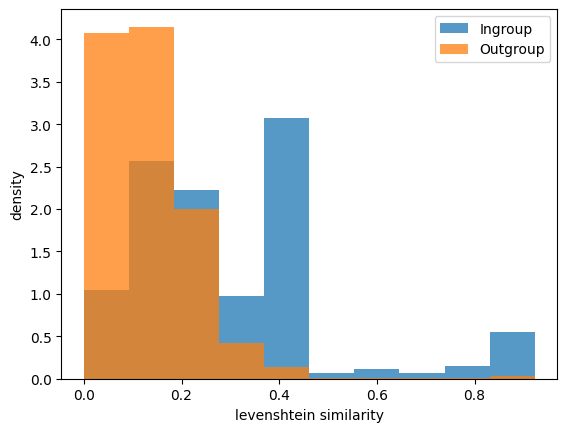

In [11]:
sim = 'levenshtein'
ingroup_lev, outgroup_lev = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_lev, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_lev, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

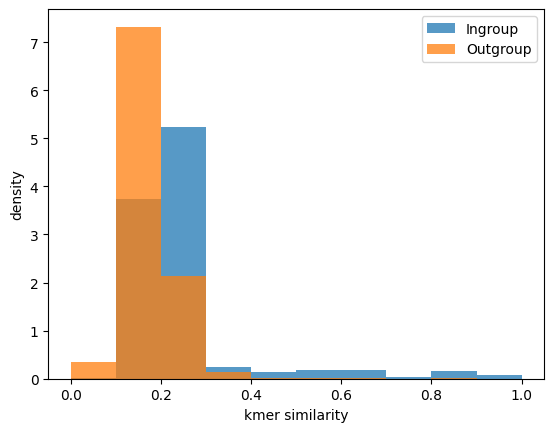

In [8]:
sim = 'kmer'
ingroup_kmer, outgroup_kmer = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_kmer, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_kmer, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

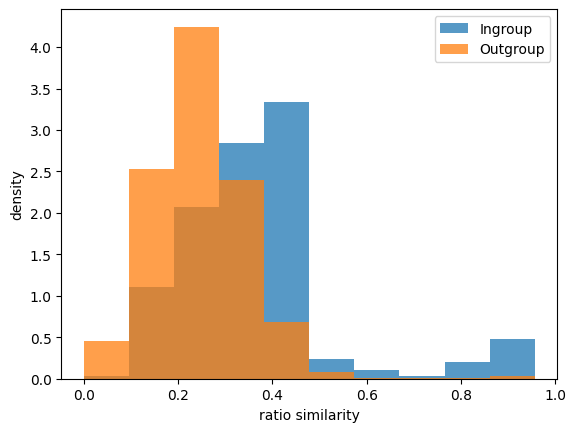

In [9]:
sim = 'ratio'
ingroup_ratio, outgroup_ratio = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_ratio, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_ratio, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

## Evaluating Deep Learning Based Methods

In [7]:
# _PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# _PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)
# PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
# PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)

In [66]:
ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)

device='cuda' if torch.cuda.is_available() else 'cpu'
ESM2_MODEL.to(device)
#PROTBERT_MODEL.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

### Defining the ACE Neural Engine

In [12]:
class AceNeuralEngine(nn.Module):
    """
    ACE Neural Engine handles the contextual sequence encoding 
    of the different peptides to generate embeddings. Once the 
    model outputs are calculated the actual represetnation
    can be chosen from the following.

    Representation options:
    - last_hidden_state: last hidden state of the transformer
    - pooler_output: output of the pooler layer
    - cls_embedding: embedding of the [CLS] token
    - mean_pooling: mean pooling of the last hidden state
    - max_pooling: max pooling of the last hidden state

    Representation implementations are based on the HuggingFace Transformers library
    and code from this Kaggle Notebook: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
    """
    def __init__(self, base_model, device, binarize=False, representation='last_hidden_state'):
        super(AceNeuralEngine, self).__init__()
        self.model = base_model
        self.device = device
        self.representation = representation
        self.binarize = binarize
        #self.rnn = nn.LSTM(320, 128, 2, batch_first=True, bidirectional=True)
        """self.mlp = nn.Sequential(
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Dropout(0.2),
                        nn.Linear(128, 1),
                        nn.Dropout(0.2),
                        nn.Sigmoid()
                    )"""
        self.model.to(self.device)

    def forward(self, inputs):
        """
        Implements the forward function of the nerural engine to get the output of the model
        before grabbing the embedding as the speccified representation.
        """
        
        # 1. Move the inputs to the correct device
        ### inputs: [batch_size, max_seq_len]
        inputs = inputs.to(self.device)
        attention_mask = inputs['attention_mask']
        model_outputs = self.model(**inputs)

        # 2. Get the correct transformer representation
        if self.representation == 'last_hidden_state':    
            representation = model_outputs.hidden_states[-1]
        
        elif self.representation == 'pooler_output':
            if hasattr(model_outputs, 'pooler_output'):
                # repesentation: [batch_size, pooler_dim]
                representation = model_outputs.pooler_output
            else:
                raise ValueError("Base model does not have a pooler_output")
        
        elif self.representation == 'cls_embedding':
            # repesentation: [batch_size, hidden_size]
            representation = model_outputs.hidden_states[-1][:, 0, :]
    
        elif self.representation=='mean_pooling':
            # repesentation: [batch_size, hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            representation = model_outputs.hidden_states[-1].mean(dim=1)

        elif self.representation=='max_pooling':
            representation = torch.max(model_outputs.hidden_states[-1], 1)[0]
                
        elif self.representation == 'mean_max_pooling':
            # repesentation: [batch_size, 2*hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            max_embeddings = torch.max(model_outputs.hidden_states[-1], 1)[0]
            representation = torch.cat((mean_embeddings, max_embeddings), 1)
        
        elif self.representation == 'concatenate_pooling':
            # Strategy: concatenate the last four layers and then pool
            # Alternative strategies: concatenate the last two layers and then pool, 
            # intercalate different layers and pool, etc.

            # repesentation: [batch_size, num_final_layers*hidden_size] 
            queried_hidden_states = torch.stack(model_outputs.hidden_states[-4:])
            representation = torch.cat(tuple(queried_hidden_states), dim=-1)

        #TODO: implement other pooling strategies (e.g. weighted_layer_pooling, attention_pooling)
        # elif self.representation == 'weighted_layer_pooling':
        # elif self.representation == 'attention_pooling':
        return representation
    
    
    
ang_untrained = AceNeuralEngine(ESM2_MODEL, device, representation='last_hidden_state')

NameError: name 'ESM2_MODEL' is not defined

In [68]:
##################################################################################
##################### Embedding Utilities ########################################
##################################################################################

def embed_sequences(sequences, model, tokenizer):
    """Calculate embeddings for a list of sequences"""
    if isinstance(tokenizer, BertTokenizer):
        if isinstance(model, BertModel):
            sequences = [re.sub('', ' ', seq) for seq in sequences]
        else:
            raise ValueError("Model must be a BertModel")
    # Tokenize sequences
    tokenized = tokenizer(list(sequences), padding=True, return_tensors='pt')

    # Get embeddings
    with torch.no_grad():
        output = model(tokenized)
        embeddings = output.cpu().numpy()
    return embeddings

def cosine_similarity(emb1, emb2):
    """Cosine similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return np.dot(a,b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

def euclidean_similarity(emb1, emb2):
    """Euclidean similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return 1 - np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b))

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_embedding_similarity(embeddings, similarity_fxn):
    """For all pairs of embeddings, calculate the similarity between them."""
    similarities = []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            embedding1 = embeddings[i]
            embedding2 = embeddings[j]
            similarities.append(similarity_fxn(embedding1, embedding2))
    return similarities

def get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ESM2_MODEL, tokenizer=ESM2_TOKENIZER, similarity='cosine'):
    """
    Calculate in/outgroup similarities for all CDR3b sequences in a dataframe
    """

    if similarity == 'cosine':
        similarity = cosine_similarity
    elif similarity == 'euclidean':
        similarity = euclidean_similarity
    else:
        raise ValueError("Similarity must be one of 'cosine' or 'euclidean'")
    
    ingroup_similarities = []
    outgroup_similarities = []
    
    # Embeddings for all ingroup/outgroup samples
    ingroup_embeddings = [embed_sequences(ingroup_sample, model, tokenizer) for ingroup_sample in ingroup_peptides]
    outgroup_embeddings = [embed_sequences(outgroup_sample, model, tokenizer) for outgroup_sample in outgroup_peptides]

    # Calculate similarities for the list of embeddings
    ingroup_similarities += [calculate_embedding_similarity(ingroup_embedding, similarity) for ingroup_embedding in ingroup_embeddings]
    outgroup_similarities += [calculate_embedding_similarity(outgroup_embedding, similarity) for outgroup_embedding in outgroup_embeddings]
    
    # Flatten the list of lists
    ingroup_similarities = [item for sublist in ingroup_similarities for item in sublist]
    outgroup_similarities = [item for sublist in outgroup_similarities for item in sublist]
    
    return ingroup_similarities, outgroup_similarities

### Pre-Trained (No Fine-Tuning)

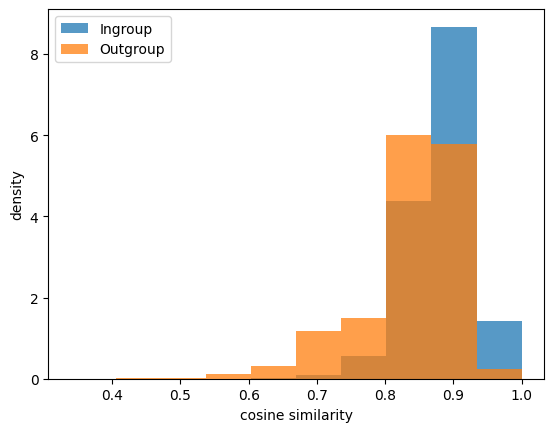

In [17]:
sim = 'cosine'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

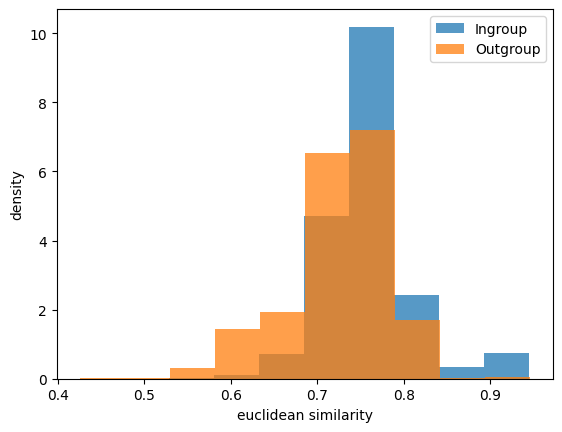

In [55]:
sim = 'euclidean'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

### Creating a Custom Dataset For Fine-Tuning 

In [13]:
def stratified_train_test_split(df, test_size=0.2, random_state=None):
    # Create a unique identifier for each combination of column_1 and column_2
    df['group_id'] = df['Epitope'].astype(str) + '_' + df['Allele'].astype(str) + '_' + df['Dataset.Origin'].astype(str)

    # Find the unique group_ids and their corresponding column_2 values
    groups = df[['group_id', 'Allele']].drop_duplicates()

    # Identify the groups that only have one instance
    group_counts = groups['Allele'].value_counts()
    singleton_groups = group_counts[group_counts == 1].index

    # Separate singleton groups and the rest
    singleton_df = groups[groups['Allele'].isin(singleton_groups)]
    groups = groups[~groups['Allele'].isin(singleton_groups)].sample(frac=1, random_state=random_state)

    # Stratified split on the groups
    train_groups, test_groups = train_test_split(groups, stratify=groups['Allele'], test_size=test_size, random_state=random_state)

    # Add the singleton groups to the train set
    train_groups = pd.concat([train_groups, singleton_df])

    # Use the group_ids to separate the original df
    train_df = df[df['group_id'].isin(train_groups['group_id'])]
    test_df = df[df['group_id'].isin(test_groups['group_id'])]

    # Drop the 'group_id' column we added for grouping
    train_df = train_df.drop(columns='group_id')
    test_df = test_df.drop(columns='group_id')

    # Drop epitopes from test that appear in train\
    #test_df = test_df[~test_df['Epitope'].isin(train_edf['Epitope'].unique())]
    test_df = pd.concat([test_df, train_df[train_df['Epitope'].isin(test_df['Epitope'].unique())]])
    train_df = train_df[~train_df['Epitope'].isin(test_df['Epitope'].unique())]
    #train_df = pd.concat([train_df, test_df[test_df['Epitope'].isin(train_epitopes)]])

    assert len(set(train_df['Epitope'].unique()).intersection(set(test_df['Epitope'].unique()))) == 0

    return train_df, test_df

In [14]:
train_df, test_df = stratified_train_test_split(data_df3, test_size=0.2, random_state=42)

In [15]:
len(test_df['Epitope'].unique())/(len(test_df['Epitope'].unique()) + len(train_df['Epitope'].unique()))

0.20055873473617808

In [86]:
test_df['Epitope'].value_counts()

TPRVTGGGAM         2128
AVFDRKSDAK          859
GLCTLVAML           284
GILGFVFTL           270
IVTDFSVIK           257
                   ... 
SIDDDTPML             1
SIISTFHLSI            1
SILGIGTVLDQAETA       1
SIMAFILGII            1
YFEHKNTTPRVHQ         1
Name: Epitope, Length: 4451, dtype: int64

In [87]:
train_df['Epitope'].value_counts()

LPRRSGAAGA       2113
KLGGALQAK        1289
RLRAEAQVK         230
YVLDHLIVV         229
VTEHDTLLY         200
                 ... 
SFLPSDFF            1
SFLVFFCAAW          1
SFLYSEIIR           1
SFMYIESIK           1
YADLYFEHKNTTP       1
Name: Epitope, Length: 17742, dtype: int64

In [16]:
train_ingroup_peptides, train_outgroup_peptides = get_all_samples(train_df, n=100)
test_ingroup_peptides, test_outgroup_peptides = get_all_samples(test_df, n=100)

100%|██████████| 4150/4150 [00:09<00:00, 456.28it/s]


In [17]:
train_df_clean = train_df[train_df['Dataset.Origin'] != 'Negative']
test_df_clean = test_df[test_df['Dataset.Origin'] != 'Negative']
clean_ingroup_peptides, clean_outgroup_peptides = get_all_samples(test_df_clean)

100%|██████████| 4149/4149 [00:06<00:00, 673.61it/s]


In [21]:
# class ImmDataset(torch.utils.data.Dataset):
#     """
#     Dataset class for ACE data. Designed to train
#     the ACE Deep Learning Module for sequence
#     dissimilarity prediction. Designed to be used
#     as a PyTorch Dataset object for triplet loss.
#     """

#     def __init__(self, data_df, tokenizer, use_hard_negatives=False, max_len=15):
#         self.data_df = self.load_from_df(data_df)
#         self.tokenizer = tokenizer
#         self.max_length = max_len


#     def __len__(self):
#         return len(self.data_df)

#     def __getitem__(self, index):
#         example = self.data_df.iloc[index]
#         return example['Epitope'], example['Binding']
        
#     def weighted_sampler(self, weighted_on):
#         """
#         Make a weighted sampler that is weighed on the product of multiple classes if need be.
#         In this case it is on the Allele and Epitope but it can be changed to be for just the 
#         epitope or just the allele or none at all.
#         """
        
#         num_samples = len(self.data_df)
#         if weighted_on==None:
#             combined_weights = [1]*num_samples
#         else:
#             weights = []
#             for weight in weighted_on:
#                 weighting = self.data_df[weight].value_counts(normalize=True)
#                 weights.append([1/np.sqrt(weighting[label]) for label in self.data_df[weight]])
#             weights_array = np.array(weights)
#             combined_weights = np.prod(weights_array, axis=0)
        
#         return torch.utils.data.WeightedRandomSampler(weights=combined_weights, num_samples=num_samples, replacement=True)
    
#     def collate_fn(self, batch):
#         """
#         Processing a batch of data in the ACE Dataset.
#         """
#         bsz = len(batch)

#         # Format the sequence for a BERT model if need be
#         if isinstance(self.tokenizer, BertTokenizer):
#             epitopes = [re.sub('', ' ', epitope) for epitope, binding in batch]

#         else:
#             epitopes, labels = zip(*batch)
#         # Tokenize and Pad according to the max_length in the batch
#         tokenized_epitopes = self.tokenizer(epitopes, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
#         return tokenized_epitopes, labels
        

#     def get_dataloader(self, batch_size, weight_on=None):
#         """
#         Call a dataloader object using the configurations of the current dataset.
#         """
#         sampler = self.weighted_sampler(weighted_on=weight_on)

#         dataloader = torch.utils.data.DataLoader(dataset=self, 
#                                             batch_size=batch_size,
#                                             sampler=sampler,
#                                             collate_fn=self.collate_fn,
#                                             pin_memory=False,
#                                             drop_last=False)
#         return dataloader


#     def load_from_df(self, data_df, use_tcr=True, use_condition=False):
#         """
#         Load data from a Pandas DataFrame.
#         """
#         cols_to_keep = ['Epitope', 'Allele', 'Binding']
#         if use_tcr:
#             cols_to_keep.append('CDR3b')
#         if use_condition:
#             cols_to_keep.append('Condition')
#         return data_df[cols_to_keep].drop_duplicates(inplace=False).reset_index(drop=True)

In [18]:
class AceDataset(torch.utils.data.Dataset):
    """
    Dataset class for ACE data. Designed to train
    the ACE Deep Learning Module for sequence
    dissimilarity prediction. Designed to be used
    as a PyTorch Dataset object for triplet loss.
    """

    def __init__(self, data_df, tokenizer, use_hard_negatives=False, max_len=15):
        self.data_df = self.load_from_df(data_df)
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.use_hard_negatives = use_hard_negatives

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        anchor = self.data_df.iloc[index]
        pos = self.get_positive_example(index)
        neg = self.get_negative_example(index)
        return anchor['Epitope'], pos, neg

    def get_positive_example(self, anchor_index):
        """
        Get a positive example for a given anchor index.
        
        Here we define a positive example as a peptide
        with the same CDR3b sequence and the same allele.
        """
        anchor = self.data_df.iloc[anchor_index]
        ddf = self.data_df.drop(anchor_index, axis=0, inplace=False)
        in_convergence_group = ddf[(ddf['CDR3b'] == anchor['CDR3b']) & (ddf['Allele'] == anchor['Allele'])]
        if len(in_convergence_group) == 0:
            return self.perturb_input(anchor_index, positive=True)
        positive = in_convergence_group.sample(1)['Epitope'].values[0]
        return positive
    
    def get_negative_example(self, anchor_index):
        """
        Get a negative example for a given anchor index.

        Here we define a negative example as a peptide
        with a different CDR3b sequence and a different allele.
        """
        anchor = self.data_df.iloc[anchor_index]
        ddf = self.data_df.drop(anchor_index, axis=0, inplace=False)
    
        not_in_convergence_group = ddf[(ddf['CDR3b'] != anchor['CDR3b']) & (ddf['Allele'] != anchor['Allele'])]
        if len(not_in_convergence_group) == 0:
            return self.perturb_input(anchor_index, positive=False)
        negative = not_in_convergence_group.sample(1)['Epitope'].values[0]

        # decision = np.random.uniform(0.0, 1.0, size=1)[0]
        # if decision < 0.15:
        #     # Return a random epitope
        #     pep_len = np.random.randint(8, 11)
        #     negative = ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=pep_len))
        #     # Make sure its not in the dataset
        #     while negative in ddf['Epitope'].values:
        #         negative = ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=pep_len))
        #     return negative
        # elif decision < 0.3:
        #     # Return a random epitope with the same allele (truly hard negative)
        #     not_in_convergence_group = ddf[(ddf['CDR3b'] != anchor['CDR3b']) & (ddf['Allele'] == anchor['Allele'])]
        #     if len(not_in_convergence_group) == 0:
        #         # Return a perturbed epitope
        #         return self.perturb_input(anchor_index, positive=True)
        #     else:
        #         # Levendist = []
        #         # for i in range(len(not_in_convergence_group.index)):
        #         #     Levendist.append(levenshtein.distance(anchor['CDR3b'], not_in_convergence_group.iloc[i]['CDR3b']))
        #         # negative = not_in_convergence_group.iloc[np.argmin(Levendist)]['Epitope']
                
        #         # Return the Epitope in the same allele that doesn't bind the TCR
        #         negative = not_in_convergence_group.sample(1)['Epitope'].values[0]
        # else:
        #     not_in_convergence_group = ddf[(ddf['CDR3b'] != anchor['CDR3b']) & (ddf['Allele'] != anchor['Allele'])]
        #     if len(not_in_convergence_group) == 0:
        #         return self.perturb_input(anchor_index, positive=False)
        #     negative = not_in_convergence_group.sample(1)['Epitope'].values[0]


        return negative
        
    def perturb_input(self, anchor_index, positive=False):
        """
        Perturb the input sequence for a given anchor index.
        """
        anchor = self.data_df.iloc[anchor_index]
        if positive:
            # Change up a single amino acid in the epitope
            perturbed = self.perturb_peptide(anchor['Epitope'])
        else:
            # Return a random epitope [can be the original]
            perturbed = self.data_df.sample(1)['Epitope'].values[0]
        return perturbed
    
    def perturb_peptide(self, peptide, swaps=3):
        """
        Perturb a peptide sequence.
        """
        peptide = list(peptide)
        perturbed_peptide = peptide.copy()
        for _ in range(swaps):
            perturbed_peptide[random.randint(0, len(peptide)-1)] = random.choice(list('ACDEFGHIKLMNPQRSTVWY'))
        return ''.join(perturbed_peptide)
        
    def weighted_sampler(self, weighted_on):
        """
        Make a weighted sampler that is weighed on the product of multiple classes if need be.
        In this case it is on the Allele and Epitope but it can be changed to be for just the 
        epitope or just the allele or none at all.
        """
        
        num_samples = len(self.data_df)
        if weighted_on==None:
            combined_weights = [1]*num_samples
        else:
            weights = []
            for weight in weighted_on:
                weighting = self.data_df[weight].value_counts(normalize=True)
                weights.append([1/np.sqrt(weighting[label]) for label in self.data_df[weight]])
            weights_array = np.array(weights)
            combined_weights = np.prod(weights_array, axis=0)
        
        return torch.utils.data.WeightedRandomSampler(weights=combined_weights, num_samples=num_samples, replacement=True)
    
    def collate_fn(self, batch):
        """
        Processing a batch of data in the ACE Dataset.
        """
        bsz = len(batch)
        
        # Extract the data triple [(anchor, positive, triple)*bsz]
        anchors, positives, negatives = zip(*batch)

        # Format the sequence for a BERT model if need be
        if isinstance(self.tokenizer, BertTokenizer):
            anchors = [re.sub('', ' ', anch) for anch in anchors]
            positives = [re.sub('', ' ', pos) for pos in positives]
            negatives = [re.sub('', ' ', neg) for neg in negatives]

        # Tokenize and Pad according to the max_length in the batch
        tokenized_anchors = self.tokenizer(anchors, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_positives = self.tokenizer(positives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_negatives = self.tokenizer(negatives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')

        return tokenized_anchors, tokenized_positives, tokenized_negatives
        

    def get_dataloader(self, batch_size, weight_on=None):
        """
        Call a dataloader object using the configurations of the current dataset.
        """
        sampler = self.weighted_sampler(weighted_on=weight_on)

        dataloader = torch.utils.data.DataLoader(dataset=self, 
                                            batch_size=batch_size,
                                            sampler=sampler,
                                            collate_fn=self.collate_fn,
                                            pin_memory=False,
                                            drop_last=False)
        return dataloader


    def load_from_df(self, data_df, use_tcr=True, use_condition=False):
        """
        Load data from a Pandas DataFrame.
        """
        cols_to_keep = ['Epitope', 'Allele']
        if use_tcr:
            cols_to_keep.append('CDR3b')
        if use_condition:
            cols_to_keep.append('Condition')
        
        return data_df[cols_to_keep].drop_duplicates(inplace=False).reset_index(drop=True)


In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.epsilon = 1e-8

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sqrt(torch.sum((anchor - positive) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        neg_dist = torch.sqrt(torch.sum((anchor - negative) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

# class TripletLoss(nn.Module):
#     def __init__(self, margin=0.2):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
#         neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
#         loss = torch.relu(pos_dist - neg_dist + self.margin)
#         return loss.mean()

# Initialize your model and loss function

_ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
_ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)
model = AceNeuralEngine(_ESM2_MODEL, representation='last_hidden_state', device=device).to(device)
loss_fn = TripletLoss(margin=1.0)

NameError: name 'device' is not defined

In [51]:
#_ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)
#model = AceNeuralEngine(_ESM2_MODEL, representation='last_hidden_state', binarize=True, device=device).to(device)
#loss_fn = nn.BCELoss()

In [52]:
# ### Get weak immunogenicity prediction dataset
# train_dset = ImmDataset(binary_train, _ESM2_TOKENIZER, max_len=15)
# train_loader = train_dset.get_dataloader(64, weight_on=None)
# train_sample = next(iter(train_loader))

# # Load the test data
# test_dset = ImmDataset(binary_test, _ESM2_TOKENIZER, max_len=15)
# test_loader = test_dset.get_dataloader(64, weight_on=None)
# test_sample = next(iter(test_loader))

In [441]:
# # Set up your optimizer
# learning_rate = 3e-5
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training_losses = []
# val_losses = []

# num_epochs = 1
# log_interval = 5
# step = 0

# # Training loop
# for epoch in range(num_epochs):
#     for tokenized_seqs, labels in train_loader:
#         # Clear the gradients
#         optimizer.zero_grad()

#         # Forward pass
#         tokenized_seqs = tokenized_seqs.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)
#         outs = model(tokenized_seqs)
    
#         # Calculate the loss
#         loss = loss_fn(outs, labels)
        
#         # Backward pass and optimization
#         loss.backward()

#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#         optimizer.step()

#         step += 1

#         # Print the loss for monitoring
#         if step % log_interval == 0:
#             training_losses.append(loss.item())
            

#             # Do validation
#             with torch.no_grad():
#                 vlosses = []
#                 for tokenized_seqs, labels in test_loader:
#                     tokenized_seqs = tokenized_seqs.to(device)
#                     labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)
#                     outs = model(tokenized_seqs)                    
#                     vloss = loss_fn(outs, labels)
#                     vlosses.append(vloss.item())
#                 val_losses.append(np.mean(vlosses))
            
#             print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")

# # Save the trained model
# #torch.save(model.state_dict(), "trained_model.pt")

Epoch [1/1], Train Loss: 0.6834052801132202, Validation Loss: 0.695691144537358
Epoch [1/1], Train Loss: 0.6732382774353027, Validation Loss: 0.6956898027232715
Epoch [1/1], Train Loss: 0.6578546762466431, Validation Loss: 0.69650201605899
Epoch [1/1], Train Loss: 0.6557575464248657, Validation Loss: 0.6974015459418297
Epoch [1/1], Train Loss: 0.6497010588645935, Validation Loss: 0.6987897608251799
Epoch [1/1], Train Loss: 0.6559188961982727, Validation Loss: 0.6985030922861326
Epoch [1/1], Train Loss: 0.6401070356369019, Validation Loss: 0.6949908797230039
Epoch [1/1], Train Loss: 0.6205819249153137, Validation Loss: 0.6956858092120716
Epoch [1/1], Train Loss: 0.6218416690826416, Validation Loss: 0.696116549273332
Epoch [1/1], Train Loss: 0.6069634556770325, Validation Loss: 0.6933053611289888
Epoch [1/1], Train Loss: 0.6305451989173889, Validation Loss: 0.6906057032091277
Epoch [1/1], Train Loss: 0.572953462600708, Validation Loss: 0.6928690299391747
Epoch [1/1], Train Loss: 0.573247

In [92]:
### Get the train and test dataset and dataloader
USE_HARD_NEGATIVES=False

train_dset = AceDataset(train_df, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, max_len=15)
train_loader = train_dset.get_dataloader(64, weight_on=['Allele', 'Epitope'])
train_sample = next(iter(train_loader))

# Load the test data
test_dset = AceDataset(test_df, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, max_len=15)
test_loader = test_dset.get_dataloader(64, weight_on=['Allele', 'Epitope'])
test_sample = next(iter(test_loader))

# Anchor, Positive, Negative
assert len(train_sample)==3
assert len(test_sample)==3

In [153]:
# Set up your optimizer
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#training_losses = []
#val_losses = []

num_epochs = 5
log_interval = 5
step = 0

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        anchor, positive, negative = batch
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate the loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass and optimization
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        step += 1

        # Update the adaptive margin
        # with torch.no_grad():
        #     margin_update = 0.1  # Define your own strategy for updating the margin
        #     loss_diff = distance_pos.mean() - distance_neg.mean()
        #     self.loss_fn.margin += margin_update * loss_diff.item()

        # Print the loss for monitoring
        if step % log_interval == 0:
            training_losses.append(loss.item())
            

            # Do validation
            with torch.no_grad():
                vlosses = []
                for batch in test_loader:
                    anchor, positive, negative = batch
                    anchor_emb = model(anchor)
                    positive_emb = model(positive)
                    negative_emb = model(negative)
                    vloss = loss_fn(anchor_emb, positive_emb, negative_emb)
                    vlosses.append(vloss.item())
                val_losses.append(np.mean(vlosses))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")


# Save the trained model
#torch.save(model.state_dict(), "trained_model.pt")

Epoch [1/5], Train Loss: 0.0021111981477588415, Validation Loss: 0.5883318012630617
Epoch [1/5], Train Loss: 0.05215222388505936, Validation Loss: 0.6075227723733799
Epoch [1/5], Train Loss: 0.04372907802462578, Validation Loss: 0.5745640695095062
Epoch [1/5], Train Loss: 0.039835575968027115, Validation Loss: 0.6032964609361984
Epoch [1/5], Train Loss: 0.036374907940626144, Validation Loss: 0.6193168678799191
Epoch [1/5], Train Loss: 0.04199003800749779, Validation Loss: 0.5735568412252374
Epoch [1/5], Train Loss: 0.024565791711211205, Validation Loss: 0.5373518515277553
Epoch [1/5], Train Loss: 0.03781061992049217, Validation Loss: 0.5904448062584207
Epoch [1/5], Train Loss: 0.006551213562488556, Validation Loss: 0.5927859891105343
Epoch [1/5], Train Loss: 0.027177918702363968, Validation Loss: 0.5794717955428201
Epoch [1/5], Train Loss: 0.04676930978894234, Validation Loss: 0.5666827299707645
Epoch [1/5], Train Loss: 0.02411043457686901, Validation Loss: 0.5575110831776181
Epoch [1/

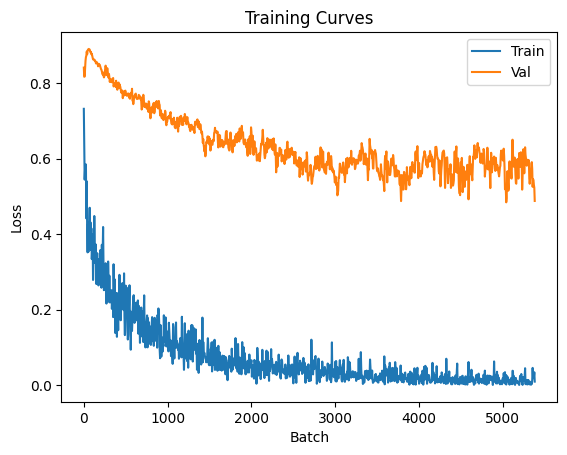

In [154]:

iters = np.arange(0, len(training_losses)*log_interval, log_interval)
plt.plot(iters, training_losses)
plt.plot(iters, val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
#plt.ylim(0, 1)
plt.legend(['Train', 'Val'])
plt.show()

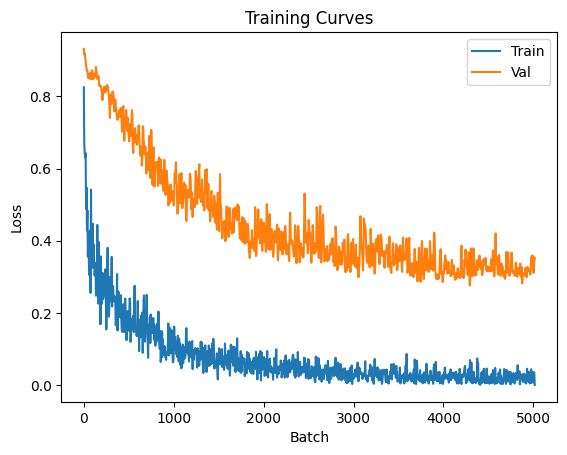

In [29]:
iters = np.arange(0, len(training_losses)*log_interval, log_interval)
plt.plot(iters, training_losses)
plt.plot(iters, val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
#plt.ylim(0, 1)
plt.legend(['Train', 'Val'])
plt.show()

In [80]:
# history = pd.DataFrame()
# history['training_loss'] = training_losses
# history['validation_loss'] = val_losses
# history.to_csv('training_history_negative_injections.csv', index=False)

In [131]:
#torch.save(model.state_dict(), "trained_model_w_negatives.pt")

### Load Model from Checkpoint

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.load_state_dict(torch.load("../src/acelib/resources/models/seq_sim_trained_model.pt", map_location=device))
model.load_state_dict(torch.load("trained_model5.pt", map_location=device))
#model.to(device)

<All keys matched successfully>

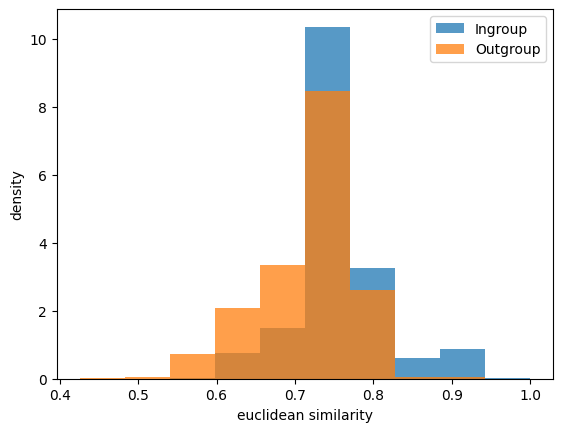

In [34]:
sim = 'euclidean'
ingroup_euclidean, outgroup_euclidean = get_embedding_similarities(clean_ingroup_peptides, clean_outgroup_peptides, model=ang_untrained, similarity=sim)
plt.hist(ingroup_euclidean, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_euclidean, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

In [36]:
sim = 'euclidean'
finetuned_ingroup_euclidean, finetuned_outgroup_euclidean = get_embedding_similarities(clean_ingroup_peptides, clean_outgroup_peptides, model=model, similarity=sim)
plt.hist(finetuned_ingroup_euclidean, alpha=0.75, density=True, label='Ingroup')
plt.hist(finetuned_outgroup_euclidean, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

NameError: name 'get_embedding_similarities' is not defined

In [40]:
ingroup_euclidean_sims = pd.DataFrame()
ingroup_euclidean_sims['ingroup_euclidean'] = ingroup_euclidean
ingroup_euclidean_sims['fine_tuned_euclidean'] = finetuned_ingroup_euclidean
ingroup_euclidean_sims.to_csv('ingroup_euclidean_sims.csv', index=False)

In [39]:
outgroup_euclidean_sims = pd.DataFrame()
outgroup_euclidean_sims['outgroup_euclidean'] = outgroup_euclidean
outgroup_euclidean_sims['finetuned_outgroup_euclidean'] = finetuned_outgroup_euclidean
outgroup_euclidean_sims.to_csv('outgroup_euclidean_sims.csv', index=False)

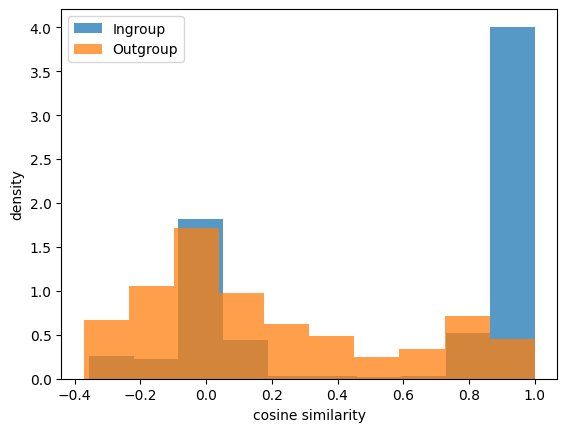

In [63]:
sim = 'cosine'
ingroup_cosine, outgroup_cosine = get_embedding_similarities(clean_ingroup_peptides, clean_outgroup_peptides, model=model, similarity=sim)
plt.hist(ingroup_cosine, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_cosine, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

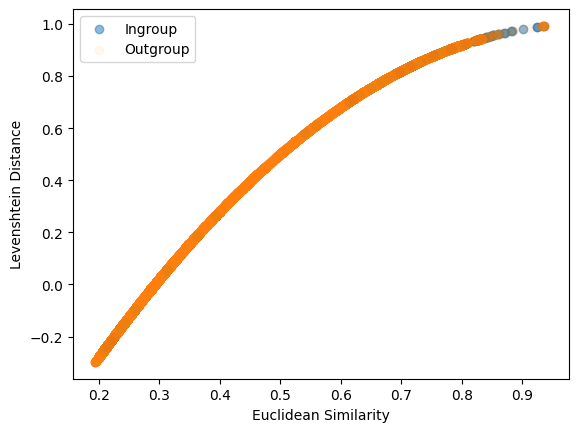

In [41]:
plt.scatter(ingroup_euclidean, ingroup_cosine, alpha=0.5, label='Ingroup')
plt.scatter(outgroup_euclidean, outgroup_cosine, alpha=0.05, label='Outgroup')
plt.xlabel('Euclidean Similarity')
plt.ylabel('Levenshtein Distance')
plt.legend()

In [ ]:
#calculate confusion matrix
def get_confusion_matrix(ingroup_sims, outgroup_sims, threshold):
    """Calculate confusion matrix for a given threshold"""
    TP = sum(np.array(ingroup_sims) > threshold)
    FP = sum(np.array(outgroup_sims) > threshold)
    TN = sum(np.array(outgroup_sims) < threshold)
    FN = sum(np.array(ingroup_sims) < threshold)
    return np.array([[TP, FP], [FN, TN]])

In [22]:
cm = get_confusion_matrix(ingroup_euclidean, outgroup_euclidean, 0.65)
cm

NameError: name 'ingroup_euclidean' is not defined

In [51]:
print(f'Precision:{cm[0,0]/(cm[0,0]+cm[0,1])}')

Precision:0.0035032530206620433


In [52]:
print(f'Recall:{cm[0, 0]/(cm[0, 0]+cm[1, 0])}')

Recall:0.6901408450704225


### Alanine Scan Method (Peptide Length = 9)

In [119]:
alanine_df = test_df_clean[['Epitope', 'Allele']]
alanine_df = alanine_df.drop_duplicates(inplace=False)
alanine_df['Binding'] = np.random.choice([0, 1], size=len(alanine_df), p=[0.5, 0.5])
alanine_df

,Epitope,Allele,Binding
41,RAKFKQLL,HLA-B*08:01,1
50,GCQEICPAC,HLA-A*02:01,1
56,NDMLVCANI,HLA-A*02:01,0
57,NMIHFAPNV,HLA-A*02:01,0
122,ELAGIGILTV,HLA-A*02:01,0
...,...,...,...
8246,GILGFVFTL,HLA-A*02:04,1
8527,KAFSPEVIPMF,HLA-B*57:06,0
8540,KSLTPEVRGYW,HLA-B*57:01,1
10181,GLCTLVAML,HLA-A*02:17,0


In [125]:
sample_df = alanine_df.sample(n=9)
while sample_df['Epitope'].unique().size != 9:
    sample_df = alanine_df.sample(n=9)
sample_df

,Epitope,Allele,Binding
50,GCQEICPAC,HLA-A*02:01,1
10304,VLEETSVML,HLA-A*01:01,0
201,EIYKRWII,HLA-B*08:01,0
3285,EEYLKAWTF,HLA-B*44:05,0
6732,MMDFFNAQM,HLA-A*02:01,0
21,NEGVKAAW,HLA-B*44:02,1
8233,EYLVSFGVW,HLA-A*24:02,0
1458,FLKEQGGL,HLA-B*08:01,0
1241,TLNAWVKVV,HLA-A*02:01,1


In [126]:
def alanine_scan(sampled_peptide_df):
    """
    Given the sampled peptide dataframe, perform an alanine scan
    
    Parameters
    ----------
    sampled_peptide_df : pd.DataFrame with the following columns:
            - Epitope: the peptide sequence
            - Allele: the MHC allele
            - Binding: the immunogenicity of the peptide
    """
    # Get the original peptide sequence
    original_peptides = sampled_peptide_df['Epitope'].values
    original_bindings = sampled_peptide_df['Binding'].values
    original_alleles = sampled_peptide_df['Allele'].values
    
    # Get the alanine scan
    alanine_scan_dict = {'Epitope':[], 'Allele':[], 'Binding':[]}
    for original_peptide, original_allele, original_binding in zip(original_peptides, original_alleles, original_bindings):
        for i in range(len(original_peptide)):
            alanine_peptide = original_peptide[:i] + 'A' + original_peptide[i+1:]
            alanine_scan_dict['Epitope'].append(alanine_peptide)
            alanine_scan_dict['Allele'].append(original_allele)
            alanine_scan_dict['Binding'].append(original_binding)
    
    return pd.DataFrame(alanine_scan_dict)

In [127]:
alanine_scan_df=alanine_scan(sample_df)
alanine_scan_df['Peptide_ID'] = [f'peptide_{i}' for i in range(len(alanine_scan_df))]
alanine_scan_df

,Epitope,Allele,Binding,Peptide_ID
0,ACQEICPAC,HLA-A*02:01,1,peptide_0
1,GAQEICPAC,HLA-A*02:01,1,peptide_1
2,GCAEICPAC,HLA-A*02:01,1,peptide_2
3,GCQAICPAC,HLA-A*02:01,1,peptide_3
4,GCQEACPAC,HLA-A*02:01,1,peptide_4
...,...,...,...,...
73,TLNAAVKVV,HLA-A*02:01,1,peptide_73
74,TLNAWAKVV,HLA-A*02:01,1,peptide_74
75,TLNAWVAVV,HLA-A*02:01,1,peptide_75
76,TLNAWVKAV,HLA-A*02:01,1,peptide_76


In [128]:
def embed_sequences(sequences, model, tokenizer, representation='last_hidden_state'):
        """Calculate embeddings for a list of sequences"""
        # Tokenize sequences
        tokenized = tokenizer(list(sequences), padding=True, return_tensors='pt')

        # Get embeddings
        with torch.no_grad():
            output = model.forward(tokenized)[:,-1]
            embeddings = output.cpu().numpy()

        assert len(embeddings) == len(sequences)
        return embeddings

embedding_array = embed_sequences(alanine_scan_df['Epitope'], model, tokenizer=ESM2_TOKENIZER)
embedding_array.shape

(78, 320)

In [129]:
from scipy.spatial.distance import cdist
def generate_distance_heatmap(embeddings_array, distance_fxn='euclidean'):
    """
    Given a 2-D embeddings array. Generate a heatmap
    that displays the euclidean or cosine
    distance between each of the arrays.
    """
    distances = cdist(embeddings_array, embeddings_array, metric=distance_fxn)
    plt.imshow(distances)
    plt.colorbar()
    plt.show()

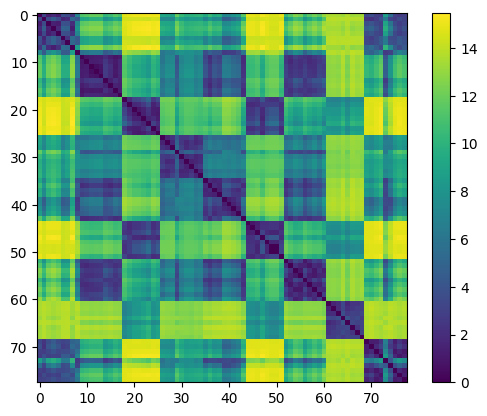

In [130]:
generate_distance_heatmap(embedding_array, 'euclidean')

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AceNeuralEngine2(nn.Module):
    """
    ACE Neural Engine handles the contextual sequence encoding 
    of the different peptides to generate embeddings. Once the 
    model outputs are calculated the actual represetnation
    can be chosen from the following.


    Representation options:CDR3b
    - pooler_output: output of the pooler layer
    - cls_embedding: embedding of the [CLS] token
    - mean_pooling: mean pooling of the last hidden state
    - max_pooling: max pooling of the last hidden state

    Representation implementations are based on the HuggingFace Transformers library
    and code from this Kaggle Notebook: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
    """

    def __init__(self, base_model, tokenizer, device=None):
        super(AceNeuralEngine2, self).__init__()
        self.model = base_model
        self.tokenizer = tokenizer
        self.device = device if device is not None else torch.device('cpu')
        self.model.to(self.device)

    def forward(self, inputs, representation='last_hidden_state'):
        """
        Implements the forward function of the nerural engine to get the output of the model
        before grabbing the embedding as the speccified representation.
        """
        
        # 1. Move the inputs to the correct device
        ### inputs: [batch_size, max_seq_len]
        if isinstance(inputs, list):
            inputs = self.tokenizer(inputs, padding=True, return_tensors='pt')
        inputs = inputs.to(self.device)
        attention_mask = inputs['attention_mask']
        model_outputs = self.model(**inputs)

        # 2. Get the correct transformer representation
        # representation: [batch_size, max_seq_len, hidden_size]
        if representation == 'last_hidden_state':    
            representation = model_outputs.hidden_states[-1]
        
        elif representation == 'pooler_output':
            if hasattr(model_outputs, 'pooler_output'):
                # repesentation: [batch_size, pooler_dim]
                representation = model_outputs.pooler_output
            else:
                raise ValueError("Base model does not have a pooler_output")
        
        elif representation == 'cls_embedding':
            # repesentation: [batch_size, hidden_size]
            representation = model_outputs.hidden_states[-1][:, 0, :]
    
        elif representation=='mean_pooling':
            # repesentation: [batch_size, hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            representation = model_outputs.hidden_states[-1].mean(dim=1)

        elif representation=='max_pooling':
            representation = torch.max(model_outputs.hidden_states[-1], 1)[0]
                
        elif representation == 'mean_max_pooling':
            # repesentation: [batch_size, 2*hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            max_embeddings = torch.max(model_outputs.hidden_states[-1], 1)[0]
            representation = torch.cat((mean_embeddings, max_embeddings), 1)
        
        elif representation == 'concatenate_pooling':
            # Strategy: concatenate the last four layers and then pool
            # Alternative strategies: concatenate the last two layers and then pool, 
            # intercalate different layers and pool, etc.

            # repesentation: [batch_size, num_final_layers*hidden_size] 
            queried_hidden_states = torch.stack(model_outputs.hidden_states[-4:])
            representation = torch.cat(tuple(queried_hidden_states), dim=-1)

        #TODO: implement other pooling strategies (e.g. weighted_layer_pooling, attention_pooling)
        # elif self.representation == 'weighted_layer_pooling':
        # elif self.representation == 'attention_pooling':
            
        return representation

    def load_weights(self, weights_path):
        """Load weights from a file"""
        self.load_state_dict(torch.load(weights_path, map_location=self.device))

    def save_weights(self, weights_path):
        """Save weights to a file"""
        torch.save(self.model.state_dict(), weights_path)

    def freeze(self):
        """Freeze the model"""
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the model"""
        for param in self.model.parameters():
            param.requires_grad = True

    @staticmethod
    def cosine_similarity(emb1, emb2):
        """Cosine similarity between two vectors"""
        a = emb1.reshape(-1)
        b = emb2.reshape(-1)
        return np.dot(a,b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

    @staticmethod
    def euclidean_similarity(emb1, emb2):
        """Euclidean similarity between two vectors"""
        a = emb1.reshape(-1)
        b = emb2.reshape(-1)
        return 1 - np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b))

    def embed_sequences(self, sequences, representation='last_hidden_state'):
        """Calculate embeddings for a list of sequences"""
        # Tokenize sequences
        tokenized = self.tokenizer(list(sequences), padding=True, return_tensors='pt')

        # Get embeddings
        with torch.no_grad():
            output = self.forward(tokenized, representation=representation)
            embeddings = output.cpu().numpy()

        assert len(embeddings) == len(sequences)
        return embeddings

    def find_paired_peptides(self, peptide_ids, peptide_sequences, representation='last_hidden_state', sim_fxn='euclidean', threshold=0.65):
        embeddings = self.embed_sequences(peptide_sequences, representation=representation)
        paired_peptide_ids = []
        for i in range(len(peptide_ids)):
            # For every peptide and every other peptide
            for j in range(len(peptide_ids)):
                if i == j:
                    continue
                if sim_fxn == 'euclidean':
                    metric =self.euclidean_similarity(embeddings[i], embeddings[j])
                    if metric >= threshold:
                        #if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        #    continue
                        #else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
                elif sim_fxn == 'cosine':
                    metric = self.cosine_similarity(embeddings[i], embeddings[j])
                    if metric >= threshold:
                        #if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        #    continue
                        #else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
                else:
                    raise ValueError("Similarity function must be 'euclidean' or 'cosine'")
        return list(paired_peptide_ids)
    
    def find_levenshtein_paired_peptides(self, peptide_ids, peptide_sequences, threshold=1):
        paired_peptide_ids = []
        for i in range(len(peptide_ids)):
            for j in range(len(peptide_ids)):
                if i == j:
                    continue
                metric = levenshtein.distance(peptide_sequences[i], peptide_sequences[j])
                if metric <= threshold:
                    if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        continue
                    else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
        return list(paired_peptide_ids)
    
    @staticmethod
    def to_paired_peptide_df(paired_peptide_triples):
        """Convert a list of paired peptides to a dataframe"""
        return pd.DataFrame(paired_peptide_triples, columns=['peptide_id_1', 'peptide_id_2', 'similarity'])

neuro = AceNeuralEngine2(_ESM2_MODEL, tokenizer=_ESM2_TOKENIZER, device=device)
#neuro.load_weights("../src/acelib/resources/models/seq_sim_trained_model.pt")
neuro.load_weights("trained_model_w_negatives.pt")

In [23]:
def compute_transitive_neighbors(
        peptide_pairs
):
    """
    Computes transitive peptide neighbors.

    Parameters
    ----------
    peptide_pairs       :   List of tuples (peptide ID, peptide ID).

    Returns
    -------
    peptide_neighbors   :   List of list of peptide IDs.
    """
    # Step 1. Create a dictionary to store peptide relationships
    peptide_dict = {}
    for peptide_id_1, peptide_id_2 in peptide_pairs:
        if peptide_id_1 not in peptide_dict:
            peptide_dict[peptide_id_1] = set()
        if peptide_id_2 not in peptide_dict:
            peptide_dict[peptide_id_2] = set()
        peptide_dict[peptide_id_1].add(peptide_id_2)
        peptide_dict[peptide_id_2].add(peptide_id_1)

    # Step 2. Find transitive peptide IDs
    transitive_peptides = []
    for peptide_id in peptide_dict:
        stack = list(peptide_dict[peptide_id])
        visited = set()
        while stack:
            curr_peptide_id = stack.pop()
            if curr_peptide_id not in visited:
                visited.add(curr_peptide_id)
                if curr_peptide_id in peptide_dict:
                    stack.extend(peptide_dict[curr_peptide_id])
        transitive_peptides.append(list(visited))

    # Step 3. De-duplicate peptide IDs
    transitive_peptides_ = []
    for i in transitive_peptides:
        duplicate = False
        for j in transitive_peptides_:
            if set(i) == j:
                duplicate = True
                break
        if not duplicate:
            transitive_peptides_.append(set(i))

    return [list(p) for p in transitive_peptides_]

def post_process(peptide_triples, top_k=1, return_dict=False):
    """
    Post-processes the peptide similarities. Create dictionary
    of peptide sequence to list of tuples sorted on similarity.

    
    """
    # Step 1. Create a dictionary to store peptide relationships
    peptide_dict = {}
    peptide_list = []

    for peptide_id_1, peptide_id_2, similarity in peptide_triples:
        if peptide_id_1 not in peptide_dict:
            peptide_dict[peptide_id_1] = []
        if peptide_id_2 not in peptide_dict:
            peptide_dict[peptide_id_2] = []
        peptide_dict[peptide_id_1].append((peptide_id_2, similarity))
        peptide_dict[peptide_id_2].append((peptide_id_1, similarity))

    # Step 2. Sort the peptide relationships and store top_k
    for peptide_id in peptide_dict:
        peptide_dict[peptide_id] = sorted(peptide_dict[peptide_id], key=lambda x: x[1], reverse=True)[:top_k]

    if return_dict:
        return peptide_dict
    else:
        for peptide_id in peptide_dict:
            for peptide_id_2, similarity in peptide_dict[peptide_id]:
                peptide_list.append((peptide_id, peptide_id_2))
        return peptide_list

## Cross Reactivity Experiment

In [24]:
a = [
"ESDPIVAQY",
"EVDPIGHLY",
"EVDPIGHVY",
"EVDPIRHYY",
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
 ]


In [25]:
b = list(combinations(["ESDPIVAQY",
    "EVDPIGHLY",
    "EVDPIGHVY",
    "EVDPIRHYY"], 2))
c = list(combinations([
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
], 2))

tps = b + c

In [26]:
sim_peps = neuro.find_paired_peptides(a, a, sim_fxn='euclidean', threshold=0.8)
sim_peps[:20]

[('ESDPIVAQY', 'EVDPIGHLY', 0.8065796494483948),
 ('ESDPIVAQY', 'EVDPIGHVY', 0.843157023191452),
 ('ESDPIVAQY', 'EVVPISHLY', 0.8538612425327301),
 ('ESDPIVAQY', 'EVVRIGHLY', 0.8010226041078568),
 ('ESDPIVAQY', 'KVNPNGHTY', 0.8348230421543121),
 ('ESDPIVAQY', 'EVNPTTHSY', 0.810103103518486),
 ('ESDPIVAQY', 'EVNPTCHLY', 0.8165620416402817),
 ('ESDPIVAQY', 'EVEPNKHIY', 0.8013944625854492),
 ('ESDPIVAQY', 'EVDPTTHCY', 0.8409017622470856),
 ('ESDPIVAQY', 'EVDPDHFYV', 0.8119596093893051),
 ('ESDPIVAQY', 'EVDPDHFYF', 0.8454004228115082),
 ('ESDPIVAQY', 'EVDPDHFYV', 0.8119596093893051),
 ('ESDPIVAQY', 'EIDKEEHLY', 0.8061755448579788),
 ('ESDPIVAQY', 'EIDKNDHLY', 0.855078786611557),
 ('ESDPIVAQY', 'ELEPKSNTY', 0.8301957994699478),
 ('EVDPIGHLY', 'ESDPIVAQY', 0.8065796494483948),
 ('EVDPIGHLY', 'EVDPIGHVY', 0.902574360370636),
 ('EVDPIGHLY', 'EVDPIRHYY', 0.9150472655892372),
 ('EVDPIGHLY', 'EVNPTCHLY', 0.8745949119329453),
 ('EVDPIGHVY', 'ESDPIVAQY', 0.843157023191452)]

In [27]:
compute_transitive_neighbors(post_process(sim_peps, 2))

[['ESDPIVAQY',
  'KVNPNGHTY',
  'EVDPTTHCY',
  'EVNPTTHSY',
  'QFDRKHHTY',
  'EVDPTSNTY',
  'EIDKEEHLY',
  'EVVPISHLY',
  'EVVRIGHLY',
  'EVEPNKHIY',
  'ELEPKSNTY',
  'EIDKNDHLY'],
 ['EVNPTCHLY', 'EVDPIRHYY', 'EVDPIGHLY', 'EVDPIGHVY'],
 ['EVDPDHFYF', 'EVDPDHFYV'],
 ['EADPTGHSY', 'EVDPTGHSF'],
 ['EVDPTSHSY', 'EDNPSGHTY', 'EVDPAGHSY', 'EMDPSRQSY', 'EVDPDDSYF'],
 ['KVDSTKDSY', 'ELEPKSHSY', 'EIDTKNHAY'],
 ['EVDTSEHIY', 'EMDSSGESY', 'EVDPDDSYV'],
 ['EVGPDHFCV'],
 ['EVGPDHFCF', 'ELDPEAHTY']]

In [261]:
sim_peps = neuro.find_paired_peptides(a, a, sim_fxn='euclidean', threshold=0.8)
sim_peps = [(s1, s2) for s1, s2, sim in sim_peps if s1 != s2]

In [52]:
tp = 0
fp = 0

for pred_pair in post_process(sim_peps):
    if pred_pair in tps:
        tp += 1
    elif (pred_pair[1], pred_pair[0]) in tps:
        tp += 1
    else:
        #print(pred_pair)
        fp += 1

print("TP: ", tp)
print("FP: ", fp)

TP:  32
FP:  2


In [54]:
len(set(b).intersection(set([(p1,p2) for p1, p2, _ in sim_peps])))/len(set(b))

0.6666666666666666

## Cell Paper

In [312]:
cell_paper_data = {
    'peptide_1': 'EAAGIGILTV',
    'peptide_2': 'AAGIGILTV',
    'peptide_3': 'ELAGIGILTV',
    'peptide_4': 'LLLGIGILVL',
    'peptide_5': 'LLLGIGILV',
    'peptide_6': 'NLSALGIFST',
    'peptide_7': 'RLSNRLLLR',
    'peptide_8': 'NLAAVGLFPA',
    'peptide_9': 'VYAALGILQG',
    'peptide_10': 'LILNIAIFFV',
    'peptide_11': 'ATSAMGTISI',
    'peptide_12': 'ISAVVGILLV',
    'peptide_13': 'TSSAIPIMTV',
    'peptide_14': 'TYSCVGVFQH',
}

In [319]:
pp = neuro.find_paired_peptides(list(cell_paper_data.keys()), list(cell_paper_data.values()), representation='last_hidden_state', sim_fxn='euclidean', threshold=0.7)
pp = post_process(pp, 1)
pp2 = neuro.find_levenshtein_paired_peptides(list(cell_paper_data.keys()), list(cell_paper_data.values()), threshold=5)
pp2 = [(seq1, seq2) for seq1, seq2, sim in pp2]
pp

[('EAAGIGILTV', 'ELAGIGILTV'),
 ('AAGIGILTV', 'LLLGIGILV'),
 ('ELAGIGILTV', 'EAAGIGILTV'),
 ('LLLGIGILVL', 'NLAAVGLFPA'),
 ('LLLGIGILV', 'AAGIGILTV'),
 ('NLSALGIFST', 'ELAGIGILTV'),
 ('NLAAVGLFPA', 'LLLGIGILVL'),
 ('VYAALGILQG', 'ATSAMGTISI'),
 ('LILNIAIFFV', 'LLLGIGILVL'),
 ('ATSAMGTISI', 'TSSAIPIMTV'),
 ('ISAVVGILLV', 'TSSAIPIMTV'),
 ('TSSAIPIMTV', 'ISAVVGILLV'),
 ('TYSCVGVFQH', 'ATSAMGTISI')]

In [314]:
from itertools import combinations
mel5mel8 = ['EAAGIGILTV', 'ELAGIGILTV', 'LLLGIGILVL', 'NLSALGIFST']
mel5mel8_paired = list(combinations(mel5mel8, 2))
mel5mel8_paired


[('EAAGIGILTV', 'ELAGIGILTV'),
 ('EAAGIGILTV', 'LLLGIGILVL'),
 ('EAAGIGILTV', 'NLSALGIFST'),
 ('ELAGIGILTV', 'LLLGIGILVL'),
 ('ELAGIGILTV', 'NLSALGIFST'),
 ('LLLGIGILVL', 'NLSALGIFST')]

In [320]:
pp2 = []
for p in pp:
    if p[0] in mel5mel8:
        pp2.append(p)
    elif p[1] in mel5mel8:
        pp2.append(p)
    else:
        continue
pp2

[('EAAGIGILTV', 'ELAGIGILTV'),
 ('ELAGIGILTV', 'EAAGIGILTV'),
 ('LLLGIGILVL', 'NLAAVGLFPA'),
 ('NLSALGIFST', 'ELAGIGILTV'),
 ('NLAAVGLFPA', 'LLLGIGILVL'),
 ('LILNIAIFFV', 'LLLGIGILVL')]

In [315]:
def calculate_precision_recall(candidate_list, reference_list):
    def are_pairs_equal(pair1, pair2):
        # This helper function checks if two pairs are equal, regardless of the order of elements.
        return set(pair1) == set(pair2)

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    for candidate_pair in candidate_list:
        found_match = False
        for reference_pair in reference_list:
            if are_pairs_equal(candidate_pair, reference_pair):
                TP += 1
                found_match = True
                break

        if not found_match:
            FP += 1

    for reference_pair in reference_list:
        found_match = False
        for candidate_pair in candidate_list:
            if are_pairs_equal(candidate_pair, reference_pair):
                found_match = True
                break

        if not found_match:
            FN += 1

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0

    return precision, recall


In [323]:
calculate_precision_recall(pp2, mel5mel8_paired)

(0.5, 0.42857142857142855)

## COVID Tiling Window 

In [55]:
spike_receptor_df = pd.read_csv("../data/spike_protein_receptor_export.csv")
spike_assay_df = pd.read_csv("../data/spike_protein_assay_export.csv")

/tmp/ipykernel_10276/466346193.py:1: DtypeWarning: Columns (11,12,14,15,18,19,20,21,22,23,29,35,44,48,49,50,58,64) have mixed types. Specify dtype option on import or set low_memory=False.
  spike_receptor_df = pd.read_csv("../data/spike_protein_receptor_export.csv")


In [56]:
pattern = re.compile(r'sars[\W_]*cov[\W_]*2', re.IGNORECASE)
spike_receptor_df = spike_receptor_df[spike_receptor_df['Epitope - Source Organism'].str.contains(pattern, na=False)]
spike_sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS \
                NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV \
                NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE \
                GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT \
                LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK \
                CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN \
                CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD \
                YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC \
                NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN \
                FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP \
                GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY \
                ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI \
                SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE \
                VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC \
                LGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAM \
                QMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN \
                TLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA \
                SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPA \
                ICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDP \
                LQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDL \
                QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD \
                SEPVLKGVKLHYT"
spike_sequence = spike_sequence.replace(" ", "")
spike_receptor_df = spike_receptor_df.iloc[[idx for idx, epitope in enumerate(spike_receptor_df['Epitope - Name']) if epitope in spike_sequence]]
spike_receptor_df = spike_receptor_df.reset_index(drop=True)

In [57]:
subset_receptor_df = spike_receptor_df[['Epitope - Name', 'Chain 2 - CDR3 Curated']].drop_duplicates()
subset_receptor_df['count'] = subset_receptor_df.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
#spike_receptor_df[['Epitope - Name', 'Chain 2 - CDR3 Curated']].drop_duplicates()['count'] = spike_receptor_df.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
subset_receptor_df[subset_receptor_df['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)

,Epitope - Name,Chain 2 - CDR3 Curated,count
8310,FPQSAPHGVVF,CASSQGYEQYF,3.0
8311,VLPFNDGVYFASTEK,CASSQGYEQYF,3.0
8312,VQPTESIVRFPNITNLCPF,CASSQGYEQYF,3.0
7126,YYVGYLQPRTFLL,CASSPLAGGNTGELFF,3.0
7127,APHGVVFLHVTYV,CASSPLAGGNTGELFF,3.0
...,...,...,...
14680,YLQPRTFLL,CAMQEMNTGELFF,2.0
195,YYVGYLQPRTFLL,CAIQEANTGELFF,2.0
15516,YLQPRTFLL,CAIQEANTGELFF,2.0
193,YYVGYLQPRTFLL,CAIQDLNTGELFF,2.0


In [6]:
#len(subset_receptor_df[subset_receptor_df['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)['Epitope - Name'].unique())
niners = subset_receptor_df[subset_receptor_df['Epitope - Name'].str.len() == 9]
niners['count'] = niners.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
niners[niners['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)

/tmp/ipykernel_6156/3810866050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  niners['count'] = niners.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')


,Epitope - Name,Chain 2 - CDR3 Curated,count
6278,TPINLVRDL,CASSPGTGSYEQYF,2.0
6279,NLNESLIDL,CASSPGTGSYEQYF,2.0
6309,NLNESLIDL,CASSPGTGGFYEQYF,2.0
6310,TPINLVRDL,CASSPGTGGFYEQYF,2.0
6332,RLFRKSNLK,CASSPGQGAYEQYF,2.0
6333,NLNESLIDL,CASSPGQGAYEQYF,2.0
5656,LPPAYTNSF,CASSLVGQPQHF,2.0
5657,RISNCVADY,CASSLVGQPQHF,2.0
4529,LEPLVDLPI,CASSLGTNYEQYF,2.0
4530,NLNESLIDL,CASSLGTNYEQYF,2.0


In [59]:
mira_full = pd.read_csv('../data/preprocessed_mira.csv')
mira_full = mira_full[['Epitope', 'CDR3b', 'ORF Coverage', 'TCR BioIdentity']]
mira_full = mira_full[mira_full['CDR3b']!='CunproductiveF']
mira_full = mira_full.drop_duplicates()
mira_subset = mira_full[mira_full['ORF Coverage'].str.contains('surface glycoprotein')]
mira_subset = mira_subset.reset_index(drop=True)
mira_subset['K-mer'] = [len(mira_subset['Epitope'][i]) for i in range(len(mira_subset))]
mira_subset[mira_subset['K-mer']==9]['CDR3b'].value_counts()


/tmp/ipykernel_10276/1447270349.py:1: DtypeWarning: Columns (30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  mira_full = pd.read_csv('../data/preprocessed_mira.csv')


CASSPGQGYEQYF       16
CASSEGQGYEQYF       14
CASSLSQGYEQYF       13
CASSLGQGYEQYF       12
CASSLGVNTEAFF        9
                    ..
CASSHGHTPNWIQYF      1
CASSLDLSTGELFF       1
CASSSGDGANVLTF       1
CASKELAGVPGELFF      1
CASSQHSGGSYNEQFF     1
Name: CDR3b, Length: 18678, dtype: int64

In [60]:
mira_subset[mira_subset['K-mer']==9]

,Epitope,CDR3b,ORF Coverage,TCR BioIdentity,K-mer
0,ADAGFIKQY,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
3,TLADAGFIK,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
4,ADAGFIKQY,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
7,TLADAGFIK,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
8,ADAGFIKQY,CASSLWASGRGGTGELFF,"ORF1ab,surface glycoprotein",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,9
...,...,...,...,...,...
70677,NSIAIPTNF,CASASGGTEAFF,surface glycoprotein,CASASGGTEAFF+TCRBV19-01+TCRBJ01-01,9
70678,NQKLIANQF,CASSLEDLLYGYTF,surface glycoprotein,CASSLEDLLYGYTF+TCRBV07-02+TCRBJ01-02,9
70679,NQKLIANQF,CSAVRDRGYTEAFF,surface glycoprotein,CSAVRDRGYTEAFF+TCRBV20-X+TCRBJ01-01,9
70682,GVVFLHVTY,CASSPRVAGGPYEQYF,surface glycoprotein,CASSPRVAGGPYEQYF+TCRBV12-X+TCRBJ02-07,9


In [61]:
def tiling_window(input_string, k):
    tiles = []
    n = len(input_string)
    
    for i in range(n - k + 1):
        tile = input_string[i:i+k]
        tiles.append(tile)
    
    return tiles
    
tiling_9mers = np.unique(tiling_window(spike_sequence, 9))

In [62]:
mira_spike9 = mira_subset[mira_subset['K-mer']==9]
mira_spike9[mira_spike9['Epitope'].isin(tiling_9mers)]

,Epitope,CDR3b,ORF Coverage,TCR BioIdentity,K-mer
0,ADAGFIKQY,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
3,TLADAGFIK,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
4,ADAGFIKQY,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
7,TLADAGFIK,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
8,ADAGFIKQY,CASSLWASGRGGTGELFF,"ORF1ab,surface glycoprotein",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,9
...,...,...,...,...,...
70677,NSIAIPTNF,CASASGGTEAFF,surface glycoprotein,CASASGGTEAFF+TCRBV19-01+TCRBJ01-01,9
70678,NQKLIANQF,CASSLEDLLYGYTF,surface glycoprotein,CASSLEDLLYGYTF+TCRBV07-02+TCRBJ01-02,9
70679,NQKLIANQF,CSAVRDRGYTEAFF,surface glycoprotein,CSAVRDRGYTEAFF+TCRBV20-X+TCRBJ01-01,9
70682,GVVFLHVTY,CASSPRVAGGPYEQYF,surface glycoprotein,CASSPRVAGGPYEQYF+TCRBV12-X+TCRBJ02-07,9


In [166]:
related_epitopes = []
for cdr3b in mira_subset['CDR3b'].unique():
    cdr3b_table = mira_subset[mira_subset['CDR3b'] == cdr3b]
    if len(cdr3b_table['Epitope'].unique()) == 1:
        continue
    else:
        related_epitopes += list(combinations(cdr3b_table['Epitope'].unique(), 2))
related_epitopes = list(set(related_epitopes))
related_epitopes

[('YEQYIKWPW', 'GVVFLHVTY'),
 ('LYNSASFSTF', 'NSASFSTFK'),
 ('AIPTNFTISV', 'LEPLVDLPI'),
 ('RLQSLQTYV', 'YEQYIKWPWY'),
 ('STGSNVFQTR', 'NLNESLIDL'),
 ('GQTGKIADY', 'QTGKIADYNY'),
 ('LYNSASFSTF', 'VRFPNITNL'),
 ('ASQSIIAYTM', 'FTNVYADSFV'),
 ('LPFFSNVTW', 'VRFPNITNL'),
 ('VQPTESIVRF', 'NATRFASVY'),
 ('FFSNVTWFH', 'GVYFASTEK'),
 ('LIDLQELGKY', 'QELGKYEQYIKW'),
 ('SWMESEFRVY', 'KLPDDFTGCV'),
 ('VQPTESIVRF', 'AEIRASANL'),
 ('AGAAAYYVGY', 'GAAAYYVGY'),
 ('LPFFSNVTW', 'FPNITNLCPF'),
 ('SQSIIAYTM', 'YYHKNNKSW'),
 ('RLQSLQTYV', 'AENSVAYSNN'),
 ('SPRRARSVA', 'TQTNSPRRAR'),
 ('KLNDLCFTNV', 'FERDISTEI'),
 ('QPYRVVVL', 'VLPPLLTDEMIAQY'),
 ('TEILPVSMTK', 'FGEVFNATRF'),
 ('KLNDLCFTNV', 'QPTESIVRF'),
 ('QYIKWPWYI', 'GEVFNATRF'),
 ('IGAEHVNNSY', 'ASQSIIAYTM'),
 ('FTNVYADSF', 'RSVASQSII'),
 ('NYLYRLFRK', 'SQSIIAYTM'),
 ('CTLKSFTVEK', 'IPTNFTISV'),
 ('FPNITNLCPF', 'TYVPAQEKNF'),
 ('PFFSNVTWF', 'RFPNITNLCPF'),
 ('FPNITNLCPF', 'KIADYNYKL'),
 ('VQPTESIVRF', 'STQDLFLPFF'),
 ('VRFPNITNL', 'VLPPLLTDEMIAQY'),


In [168]:
print(len(related_epitopes))

def remove_reversed_tuples(lst):
    # Check if the list contains only tuples
    if not all(isinstance(item, tuple) for item in lst):
        return None
    
    # Convert the list to a set of tuples
    set_of_tuples = set(lst)
    
    # Initialize a new list to store the filtered tuples
    filtered_list = []
    
    # Check if the reversed tuple is in the set, and add to the filtered list if not
    for tpl in lst:
        reversed_tpl = tuple(reversed(tpl))
        if reversed_tpl not in set_of_tuples:
            filtered_list.append(tpl)
    
    return filtered_list

related_epitopes = remove_reversed_tuples(related_epitopes)
print(len(related_epitopes))

2312


In [63]:
all_queries = list(set(tiling_9mers).union(set(mira_spike9['Epitope'])))
positive_queries = list(mira_spike9['Epitope'].unique())

In [73]:
pred_related_peptides = neuro.find_paired_peptides(all_queries, all_queries, sim_fxn='euclidean', threshold=0.8)
#pred_levenshtein_peptides = neuro.find_levenshtein_paired_peptides(all_queries, all_queries, threshold=7)
#pred_levenshtein_peptides = [(s1, s2) for s1, s2, sim in pred_levenshtein_peptides if s1 != s2]
#$pred_related_peptides = [(s1, s2) for s1, s2, _ in pred_related_peptides if s1 != s2]
spike_groups = compute_transitive_neighbors(post_process(pred_related_peptides))

In [78]:
set(['TRTQLPPAY',
  'FQPTNGVGY',
  'LMDLEGKQG',
  'KVCEFQFCN',
  'PTESIVRFP',
  'SYGFQPTNG',
  'QSYGFQPTN',
  'KSNIIRGWI',
  'TESIVRFPN',
  'VTTEILPVS',
  'VSVITPGTN',
  'HADQLTPTW',
  'ICAQKFNGL',
  'QNAQALNTL',
  'RDPQTLEIL',
  'DCTMYICGD',
  'QTSNFRVQP',
  'ASYQTQTNS',
  'PTNGVGYQP',
  'FTRGVYYPD']).intersection(set(spike_pos))

{'FQPTNGVGY'}

In [74]:
[group for group in spike_groups if set(group).intersection(set(spike_pos)) != set()]

[['QKLIANQFN',
  'MQMAYRFNG',
  'VADYSVLYN',
  'AGFIKQYGD',
  'PGQTGKIAD',
  'IAIPTNFTI',
  'VASQSIIAY'],
 ['RVDFCGKGY',
  'YLQPRTFLL',
  'VYAWNRKRI',
  'VYYPDKVFR',
  'VIKVCEFQF',
  'YFPLQSYGF'],
 ['HGVVFLHVT',
  'SNVTWFHAI',
  'MIAQYTSAL',
  'QMAYRFNGI',
  'VNCTEVPVA',
  'VDLPIGINI',
  'VVIGIVNNT',
  'NQKLIANQF',
  'VTWFHAIHV'],
 ['TRTQLPPAY',
  'FQPTNGVGY',
  'LMDLEGKQG',
  'KVCEFQFCN',
  'PTESIVRFP',
  'SYGFQPTNG',
  'QSYGFQPTN',
  'KSNIIRGWI',
  'TESIVRFPN',
  'VTTEILPVS',
  'VSVITPGTN',
  'HADQLTPTW',
  'ICAQKFNGL',
  'QNAQALNTL',
  'RDPQTLEIL',
  'DCTMYICGD',
  'QTSNFRVQP',
  'ASYQTQTNS',
  'PTNGVGYQP',
  'FTRGVYYPD'],
 ['SFELLHAPA',
  'PGTNTSNQV',
  'IPTNFTISV',
  'LVRDLPQGF',
  'TKTSVDCTM',
  'VYADSFVIR',
  'SKHTPINLV',
  'FGTTLDSKT',
  'VLHSTQDLF',
  'EIDRLNEVA',
  'TTLDSKTQS',
  'VAKNLNESL',
  'IAVEQDKNT',
  'TSVDCTMYI',
  'KCTLKSFTV',
  'NGVEGFNCY',
  'FLMDLEGKQ'],
 ['DLICAQKFN', 'ADAGFIKQY', 'AQVKQIYKT'],
 ['CDIPIGAGI', 'ENQKLIANQ', 'LQIPFAMQM', 'QVAVLYQDV', 'NATNVVIKV'],


In [69]:
spike_pos = mira_spike9['Epitope'].unique()
'VVFLHVTYV' in spike_pos

True

In [71]:
sorted(spike_pos)

['ADAGFIKQY',
 'AEIRASANL',
 'AENSVAYSN',
 'AEVQIDRLI',
 'ALDPLSETK',
 'ALNTLVKQL',
 'APGQTGKIA',
 'AQALNTLVK',
 'ASANLAATK',
 'CNDPFLGVY',
 'EYVSQPFLM',
 'FERDISTEI',
 'FEYVSQPFL',
 'FFSNVTWFH',
 'FIAGLIAIV',
 'FLPFFSNVT',
 'FPQSAPHGV',
 'FQPTNGVGY',
 'FTNVYADSF',
 'FVFKNIDGY',
 'GAAAYYVGY',
 'GAEHVNNSY',
 'GEVFNATRF',
 'GPKKSTNLV',
 'GQTGKIADY',
 'GRLQSLQTY',
 'GSFCTQLNR',
 'GTHWFVTQR',
 'GTITSGWTF',
 'GVVFLHVTY',
 'GVYFASTEK',
 'GVYYHKNNK',
 'HLMSFPQSA',
 'IGAGICASY',
 'IITTDNTFV',
 'INITRFQTL',
 'IPFAMQMAY',
 'IPTNFTISV',
 'KEIDRLNEV',
 'KIADYNYKL',
 'KVFRSSVLH',
 'LEPLVDLPI',
 'LGAENSVAY',
 'LITGRLQSL',
 'LLALHRSYL',
 'LLFNKVTLA',
 'LLLQYGSFC',
 'LLQYGSFCT',
 'LPFFSNVTW',
 'LPFNDGVYF',
 'LPPAYTNSF',
 'LQIPFAMQM',
 'LTDEMIAQY',
 'MTSCCSCLK',
 'NATRFASVY',
 'NGVEGFNCY',
 'NLNESLIDL',
 'NQKLIANQF',
 'NSASFSTFK',
 'NSIAIPTNF',
 'NYLYRLFRK',
 'NYNYLYRLF',
 'PFFSNVTWF',
 'PYRVVVLSF',
 'QPTESIVRF',
 'QTNSPRRAR',
 'QYIKWPWYI',
 'RFDNPVLPF',
 'RISNCVADY',
 'RLDKVEAEV',
 'RLFRKSNLK',
 'RLNE

In [183]:
len(post_processed_preds)

3718

In [188]:
calculate_precision_recall(post_processed_preds, related_epitopes)

(0.010758472296933835, 0.02100840336134454)

In [182]:
post_processed_preds = post_process(pred_related_peptides)

In [27]:
nonamers = {f"peptide_{i}": epitope for i, epitope in enumerate(niners['Epitope - Name'].unique())}
tru_paired_spike_nonamers = [('TPINLVRDL', 'NLNESLIDL'), ('RLFRKSNLK', 'NLNESLIDL'), ('LPPAYTNSF', 'RISNCVADY'), ('LEPLVDLPI', 'NLNESLIDL'), ('LTDEMIAQY', 'YLQPRTFLL')]
#spike_predicted_pairs = neuro.find_paired_peptides(list(nonamers.values()), list(nonamers.values()), representation='last_hidden_state', sim_fxn='euclidean', threshold=0.8)
#spike_predicted_pairs = neuro.find_paired_peptides(tiling_9mers, tiling_9mers, threshold=0.70)
#spike_levenshtein_pairs = neuro.find_levenshtein_paired_peptides(tiling_9mers, tiling_9mers, threshold=7)
#spike_predicted_pairs

In [27]:
assert [item in spike_sequence for item in list(nonamers.values())]
assert [item in tiling_9mers for item in list(nonamers.keys())]

In [274]:
post_process(sim_peps)

[('ESDPIVAQY', 'EVDPIGHLY'),
 ('ESDPIVAQY', 'EVDPIRHYY'),
 ('ESDPIVAQY', 'EMDPSRQSY'),
 ('EVDPIGHLY', 'EVDPAGHSY'),
 ('EVDPIGHLY', 'EVDPIRHYY'),
 ('EVDPIGHLY', 'EVDPIGHVY'),
 ('EVDPIGHVY', 'EVDPIGHLY'),
 ('EVDPIGHVY', 'EVDPAGHSY'),
 ('EVDPIGHVY', 'KVNPNGHTY'),
 ('EVDPIRHYY', 'EVEPNKHIY'),
 ('EVDPIRHYY', 'EVDPIGHLY'),
 ('EVDPIRHYY', 'EVDPAGHSY'),
 ('EADPTGHSY', 'EVDPAGHSY'),
 ('EADPTGHSY', 'EVDPTSNTY'),
 ('EADPTGHSY', 'EVNPTTHSY'),
 ('EVVPISHLY', 'EVNPTTHSY'),
 ('EVVPISHLY', 'EVEPNKHIY'),
 ('EVVPISHLY', 'EVDPIRHYY'),
 ('EVDPTSNTY', 'EVDPTSHSY'),
 ('EVDPTSNTY', 'EVNPTTHSY'),
 ('EVDPTSNTY', 'EADPTGHSY'),
 ('EVDPAGHSY', 'EVDPIGHLY'),
 ('EVDPAGHSY', 'EVDPIGHVY'),
 ('EVDPAGHSY', 'EMDPSRQSY'),
 ('EVDPTGHSF', 'EVGPDHFCF'),
 ('EVDPTGHSF', 'KVNPNGHTY'),
 ('EVDPTGHSF', 'EVDPDHFYF'),
 ('EVDPTSHSY', 'EVDPTTHCY'),
 ('EVDPTSHSY', 'EVNPTTHSY'),
 ('EVDPTSHSY', 'EVDPTSNTY'),
 ('EVVRIGHLY', 'EVDPIGHVY'),
 ('EVVRIGHLY', 'EVNPTCHLY'),
 ('EVVRIGHLY', 'KVNPNGHTY'),
 ('EDNPSGHTY', 'EVDPAGHSY'),
 ('EDNPSGHTY',

In [189]:
calculate_precision_recall(pred_levenshtein_peptides, related_epitopes)

(0.0030753205525656606, 0.19661733615221988)

In [190]:
calculate_precision_recall(pred_related_peptides, related_epitopes)

(0.0, 0.0)

In [191]:
calculate_precision_recall(post_processed_preds, related_epitopes)

(0.010758472296933835, 0.02100840336134454)

In [28]:
calculate_precision_recall([(seq1, seq2) for seq1, seq2, sim in spike_predicted_pairs], tru_paired_spike_nonamers)

(1.4186610676843196e-05, 0.2)

In [29]:
calculate_precision_recall([(seq1, seq2) for seq1, seq2, sim in spike_predicted_pairs], list(combinations(list(nonamers.values()), 2)))

(0.006454907857963654, 0.1404320987654321)

In [30]:
calculate_precision_recall([(seq1, seq2) for seq1, seq2, sim in spike_levenshtein_pairs], tru_paired_spike_nonamers)

(1.775583945169968e-05, 0.4)

In [31]:
calculate_precision_recall([(seq1, seq2) for seq1, seq2, sim in spike_levenshtein_pairs], list(combinations(list(nonamers.values()), 2)))

(0.0054687985511235005, 0.19012345679012346)

In [32]:
#compute_transitive_neighbors([(seq1, seq2) for seq1, seq2, sim in spike_predicted_pairs])
compute_transitive_neighbors(related_epitopes)

[['WTAGAAAYYV',
  'LPFFSNVTW',
  'APHGVVFLHV',
  'LTDEMIAQYT',
  'VPLHGTIL',
  'VEAEVQIDRL',
  'LPFFSNVTWF',
  'FERDISTEIY',
  'LPFNDGVYFA',
  'AENSVAYSN',
  'RISNCVADY',
  'KIADYNYKL',
  'TVYDPLQPELDSFK',
  'IPTNFTISV',
  'FFSNVTWFH',
  'VQPTESIVRF',
  'VQIDRLITGR',
  'PFFSNVTWF',
  'WTAGAAAYY',
  'GQTGKIADY',
  'NSIAIPTNF',
  'VYADSFVIR',
  'YYVGYLQPRTF',
  'FPQSAPHGV',
  'TGSNVFQTR',
  'GYQPYRVVVL',
  'IGAEHVNNSY',
  'FIAGLIAIV',
  'AEVQIDRLI',
  'LYNSASFSTF',
  'NYNYLYRLF',
  'TEILPVSMTK',
  'GTHWFVTQR',
  'TLKSFTVEK',
  'YEQYIKWPWY',
  'FPQSAPHGVVF',
  'YSVLYNSASF',
  'HLMSFPQSA',
  'QPTESIVRF',
  'AEIRASANL',
  'RSVASQSII',
  'REGVFVSNGTHW',
  'LLLQYGSFC',
  'LPPAYTNSF',
  'RQIAPGQTGK',
  'TLDSKTQSL',
  'APGQTGKIA',
  'LLQYGSFCT',
  'APHGVVFL',
  'FERDISTEI',
  'YLQPRTFL',
  'IYSKHTPINL',
  'SIIAYTMSL',
  'LTDEMIAQY',
  'RLQSLQTYV',
  'RLFRKSNLK',
  'AENSVAYSNN',
  'FTNVYADSFV',
  'GAAAYYVGY',
  'GVYFASTEK',
  'AEIRASANLA',
  'QYIKWPWYI',
  'SEPVLKGVKL',
  'YHLMSFPQSA',
  'NSASFS

In [ ]:
#81 positive nonamers
#17 positive nonamers w 2 CDR3
#1 positive nonamers w 1 CDR3

### Checking to See if Clustering Embeddings Works Well

In [67]:
from sklearn.cluster import KMeans, AgglomerativeClustering

def cluster_embeddings(batched_tensor, num_clusters=None, cluster_size=None, method='kmeans'):
    batched_tensor = batched_tensor.detach().cpu().numpy()
    n_points = batched_tensor.shape[0]
    
    if num_clusters is not None and num_clusters > n_points:
        num_clusters = n_points  # Each point is a separate cluster

    if cluster_size is not None and cluster_size > n_points:
        cluster_size = n_points  # All points in a single cluster

    if num_clusters is not None:
        n_clusters = num_clusters
    elif cluster_size is not None:
        n_clusters = n_points // cluster_size
    else:
        raise ValueError("You must specify at least one of 'num_clusters' or 'cluster_size'")

    matrix = batched_tensor.reshape(n_points, -1)  # Reshape the tensor into a 2-D matrix

    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("'method' must be 'kmeans' or 'agglomerative'")

    model.fit(matrix)
    return model.labels_

In [58]:
sampled_cdr3bs = np.random.choice(data_df2['CDR3b'].unique(), size=10, replace=False)
sample_df = data_df2[data_df2['CDR3b'].isin(sampled_cdr3bs)]
sample_df

,CDR3b,Epitope,Allele
430,CASSPVVGGTGELFF,IMNDMPIYM,HLA-A*02:01
485,CASSPVVGGTGELFF,FLCMKALLL,HLA-A*02:01
490,CSAEGNTEAFF,FLCMKALLL,HLA-A*02:01
1047,CASSQETIAKNIQYF,VTEHDTLLY,HLA-A*01:01
1048,CASSQETIAKNIQYF,TPRVTGGGAM,HLA-B*07:02
1049,CASSQETIAKNIQYF,LPRRSGAAGA,HLA-B*07:02
1628,CAWKASGNTIYF,LPRRSGAAGA,HLA-B*07:02
1629,CAWKASGNTIYF,TPRVTGGGAM,HLA-B*07:02
4008,CASSYTNNSPLHF,TPRVTGGGAM,HLA-B*07:02
4009,CASSYTNNSPLHF,LPRRSGAAGA,HLA-B*07:02


In [80]:
embeddings = neuro(list(all_queries), representation='last_hidden_state')

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 7.79 GiB total capacity; 6.40 GiB already allocated; 21.94 MiB free; 6.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [70]:
embeddings.shape

torch.Size([1361, 320])

In [76]:
agg_cluster_labels = cluster_embeddings(embeddings, num_clusters=10, method='agglomerative')
kmeans_cluster_labels = cluster_embeddings(embeddings, num_clusters=10, method='kmeans')

/home/dxk/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [77]:
from sklearn.metrics import silhouette_score
silhouette_score(embeddings.detach().cpu().numpy(), agg_cluster_labels)

0.1187405

In [78]:
silhouette_score(embeddings.detach().cpu().numpy(), kmeans_cluster_labels)

0.12958853

In [40]:
embeddings.shape

torch.Size([1361, 16, 320])

In [163]:
tru_paired_spike_nonamers

[('TPINLVRDL', 'NLNESLIDL'),
 ('RLFRKSNLK', 'NLNESLIDL'),
 ('LPPAYTNSF', 'RISNCVADY'),
 ('LEPLVDLPI', 'NLNESLIDL'),
 ('LTDEMIAQY', 'YLQPRTFLL')]

In [35]:
for pair in tru_paired_spike_nonamers:
    if seq_to_cluster[pair[0]] == seq_to_cluster[pair[1]]:
        print(pair)
    else:
        print(f"{pair} not in same cluster")
    

('TPINLVRDL', 'NLNESLIDL')
('RLFRKSNLK', 'NLNESLIDL') not in same cluster
('LPPAYTNSF', 'RISNCVADY') not in same cluster
('LEPLVDLPI', 'NLNESLIDL') not in same cluster
('LTDEMIAQY', 'YLQPRTFLL') not in same cluster


In [31]:
seq_to_cluster = {epi: cluster for epi, cluster in zip(tiling_9mers, cluster_labels)}
cluster_to_seq = {cluster_id: [epi for epi, cluster in zip(tiling_9mers, cluster_labels) if cluster == cluster_id] for cluster_id in np.unique(cluster_labels)}
cluster_to_seq
#niners

{0: ['AALQIPFAM',
  'AGICASYQT',
  'AGLIAIVMV',
  'AIVMVTIML',
  'ALGKLQDVV',
  'ALLAGTITS',
  'ALTGIAVEQ',
  'CDIPIGAGI',
  'CFTNVYADS',
  'CLIGAEHVN',
  'CLKGCCSCG',
  'CPFGEVFNA',
  'CSFGGVSVI',
  'DDFTGCVIA',
  'DILSRLDKV',
  'DIPIGAGIC',
  'DISGINASV',
  'DLCFTNVYA',
  'DLLFNKVTL',
  'DLPIGINIT',
  'DVNCTEVPV',
  'ELLHAPATV',
  'EPLVDLPIG',
  'FCNDPFLGV',
  'FGAGAALQI',
  'FIAGLIAIV',
  'FLVLLPLVS',
  'FNDGVYFAS',
  'FNFNGLTGT',
  'FVFLVLLPL',
  'FVSGNCDVV',
  'GAISSVLND',
  'GCLIGAEHV',
  'GDCLGDIAA',
  'GDISGINAS',
  'GFIAGLIAI',
  'GICASYQTQ',
  'GIGVTQNVL',
  'GINASVVNI',
  'GINITRFQT',
  'GIVNNTVYD',
  'GLIAIVMVT',
  'GLTGTGVLT',
  'GNCDVVIGI',
  'GWIFGTTLD',
  'IAGLIAIVM',
  'IGAGICASY',
  'IIRGWIFGT',
  'IRGWIFGTT',
  'ISGINASVV',
  'IVMVTIMLC',
  'IVNNATNVV',
  'IWLGFIAGL',
  'KFNGLTVLP',
  'KLIANQFNS',
  'KLNDLCFTN',
  'LCFTNVYAD',
  'LIAIVMVTI',
  'LIANQFNSA',
  'LIVNNATNV',
  'LLAGTITSG',
  'LLFNKVTLA',
  'LLHAPATVC',
  'LLIVNNATN',
  'LNDLCFTNV',
  'LNRALTGIA',
  'LPDD

In [64]:
embeddings = embed_sequences(sample_df['Epitope'], model, tokenizer=ESM2_TOKENIZER)

cluster_labels = cluster_embeddings(embeddings, num_clusters=5, method='agglomerative')
cluster_labels

array([2, 4, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1])

In [14]:
sample_df['cluster_id'] = cluster_labels
sample_df[['CDR3b', 'Epitope', 'Allele', 'cluster_id']]

NameError: name 'cluster_labels' is not defined

In [144]:
len(subset_receptor_df['Chain 2 - CDR3 Curated'].unique())

15587

In [146]:
55/1265

0.043478260869565216

In [127]:
spike_receptor_df[spike_receptor_df['Chain 2 - CDR3 Curated']=="CASSPLAGGNTGELFF"]

,Receptor - Group IRI,Receptor - IEDB Receptor ID,Receptor - Reference Name,Receptor - Type,Reference - IEDB IRI,Epitope - IEDB IRI,Epitope - Name,Epitope - Source Molecule,Epitope - Source Organism,Assay - Type,...,Chain 2 - CDR1 Start Curated,Chain 2 - CDR1 End Curated,Chain 2 - CDR1 Start Calculated,Chain 2 - CDR1 End Calculated,Chain 2 - CDR2 Curated,Chain 2 - CDR2 Calculated,Chain 2 - CDR2 Start Curated,Chain 2 - CDR2 End Curated,Chain 2 - CDR2 Start Calculated,Chain 2 - CDR2 End Calculated
7126,http://www.iedb.org/receptor/111654,115428,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1075131,YYVGYLQPRTFLL,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7127,http://www.iedb.org/receptor/111654,115430,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074847,APHGVVFLHVTYV,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14660,http://www.iedb.org/receptor/181725,201602,NaN,alphabeta,http://www.iedb.org/reference/1037882,http://www.iedb.org/epitope/1309147,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Receptor - Group IRI,Receptor - IEDB Receptor ID,Receptor - Reference Name,Receptor - Type,Reference - IEDB IRI,Epitope - IEDB IRI,Epitope - Name,Epitope - Source Molecule,Epitope - Source Organism,Assay - Type,...,Chain 2 - CDR1 Start Curated,Chain 2 - CDR1 End Curated,Chain 2 - CDR1 Start Calculated,Chain 2 - CDR1 End Calculated,Chain 2 - CDR2 Curated,Chain 2 - CDR2 Calculated,Chain 2 - CDR2 Start Curated,Chain 2 - CDR2 End Curated,Chain 2 - CDR2 Start Calculated,Chain 2 - CDR2 End Calculated
2,http://www.iedb.org/receptor/8670,9437,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,http://www.iedb.org/receptor/8670,9437,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1075108,VQPTESIVRFPNITNLCPF,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,http://www.iedb.org/receptor/8678,9445,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,http://www.iedb.org/receptor/8681,9448,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,http://www.iedb.org/receptor/8684,9451,NaN,alphabeta,http://www.iedb.org/reference/1036945,http://www.iedb.org/epitope/1074888,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,T cell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17087,http://www.iedb.org/receptor/197176,217430,NR1C,alphabeta,http://www.iedb.org/reference/1039307,http://www.iedb.org/epitope/1309147,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,T cell,...,NaN,NaN,27.0,31.0,NaN,SQIVND,NaN,NaN,49.0,54.0
17088,http://www.iedb.org/receptor/197183,217439,pYLQ7,alphabeta,http://www.iedb.org/reference/1040001,http://www.iedb.org/epitope/1309147,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,T cell,...,NaN,NaN,28.0,32.0,NaN,FQNEAQ,NaN,NaN,50.0,55.0
17089,http://www.iedb.org/receptor/197184,217440,RLQ3,alphabeta,http://www.iedb.org/reference/1040001,http://www.iedb.org/epitope/54725,RLQSLQTYV,Spike glycoprotein,SARS-CoV2,T cell,...,NaN,NaN,25.0,29.0,NaN,FQNNGV,NaN,NaN,47.0,52.0
17090,http://www.iedb.org/receptor/197198,217457,YLQ36,alphabeta,http://www.iedb.org/reference/1041037,http://www.iedb.org/epitope/1309147,YLQPRTFLL,Spike glycoprotein,SARS-CoV2,T cell,...,NaN,NaN,27.0,31.0,NaN,FQNEAQ,NaN,NaN,49.0,54.0


### Training an MLP on Ingroups and Outgroups

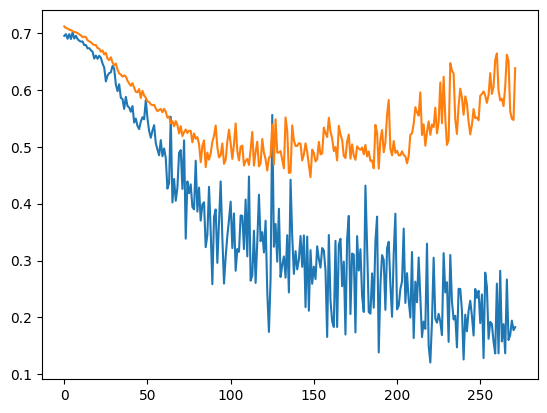

In [427]:
# plt.plot(training_losses)
# plt.plot(val_losses)

In [70]:
def get_all_peptide_groupings(df, num_negative=100):
    """
    Get all the peptides groupings as either in-group (1) or outgroup (0).
    Cuts off the number of negatives at num_negatives due to the fact that
    most peptides have a many orders of magnitude larger number of outgroup peptides.
    
    Args:
        df: pd.DataFrame has the columns
            ['CDR3b', 'Epitope', 'Allele']
        num_negative: Number of negative examples to sample for each positive example
    """
    query_peps = []
    comparator_peps = []
    labels = []
    for cdr3b in tqdm(df['CDR3b'].unique()):
        # Get the ingroup and outgroup peptides and then calc
        ingrouped = df[df['CDR3b'] == cdr3b]['Epitope'].values
        outgrouped = df[df['CDR3b'] != cdr3b].sample(n=num_negative)['Epitope'].values
        
        # Pairwise go through the ingrouped peptides

        for i in range(len(ingrouped)):
            for j in range(i+1, len(ingrouped)):
                epitope1 = ingrouped[i]
                epitope2 = ingrouped[j]
                if epitope1 == epitope2:
                    continue
                query_peps.append(epitope1)
                comparator_peps.append(epitope2)
                labels.append(1)

        # Pairwise go through the outgrouped peptides

        for i in range(len(outgrouped)):
            for j in range(i+1, len(outgrouped)):
                epitope1 = outgrouped[i]
                epitope2 = outgrouped[j]
                if epitope1 == epitope2:
                    continue
                query_peps.append(epitope1)
                comparator_peps.append(epitope2)
                labels.append(0)

    return pd.DataFrame({'Query':query_peps,
                         'Reference': comparator_peps,
                         'Label': labels})


In [71]:
res_df = get_all_peptide_groupings(train_df, num_negative=4)

res_df.head(20)

100%|██████████| 5550/5550 [00:06<00:00, 805.07it/s]


,Query,Reference,Label
0,GLCTLVAML,LLLDRLNQL,1
1,GLCTLVAML,GILGFVFTL,1
2,LLLDRLNQL,GILGFVFTL,1
3,GTSGSPIINR,LLLDRLNQL,0
4,GTSGSPIINR,LPRRSGAAGA,0
5,GTSGSPIINR,LPRRSGAAGA,0
6,LLLDRLNQL,LPRRSGAAGA,0
7,LLLDRLNQL,LPRRSGAAGA,0
8,GLCTLVAML,TPRVTGGGAM,1
9,ELAGIGILTV,IVTDFSVIK,0


In [95]:
class AceMLP(nn.Module):
    """
    ACE Multilayer Perceptron for predicting in-group and out-group peptides
    
    Confounded by MHC, but we purposely remain MHC agnostic
    """

    def __init__(self, tokenizer, embedding_module, device, embed_dim=320):
        super(AceMLP, self).__init__()     
        self.device = device
        self.tokenizer = tokenizer
        self.embedding_module = embedding_module.to(self.device)


        self.embed_dim = embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(2*self.embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, tokenized_queries, tokenized_references):
        #tokenized_queries = self.tokenizer(queries, padding=True, return_tensors='pt').to(self.device)
        #tokenized_references = self.tokenizer(references, padding=True, return_tensors='pt').to(self.device)
        tokenized_queries = {k: v.to(self.device) for k, v in tokenized_queries.items()}
        tokenized_references = {k: v.to(self.device) for k, v in tokenized_references.items()}
        
        with torch.no_grad():
            # Embed the query and reference peptides [batch_size, embed_dim]
            ### Grab the last layer output from the embedding module and take the first token hidden state embedding
            query_emb = self.embedding_module(**tokenized_queries).hidden_states[-1][:, 0, :]
            reference_emb = self.embedding_module(**tokenized_references).hidden_states[-1][:, 0, :]
        
        # Concatenate the embeddings [batch_size, 2*embed_dim]
        concat = torch.cat([query_emb, reference_emb], dim=-1)
        return self.mlp(concat)

class AceMLPDataset(torch.utils.data.Dataset):
    """
    Dataset class for ACE data. Designed to train
    the ACE Deep Learning Module for sequence
    dissimilarity prediction. Designed to be used
    to train a MLP for binary classification of in-group
    and out-group peptides.
    """
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return row['Query'], row['Reference'], row['Label']
    
    def collate_fn(self, batch):
        queries, references, labels = zip(*batch)
        tokenized_queries = self.tokenizer(queries, padding=True, return_tensors='pt')
        tokenized_references = self.tokenizer(references, padding=True, return_tensors='pt')
        return tokenized_queries, tokenized_references, torch.FloatTensor(labels)
    
    def get_dataloader(self, batch_size):
        dataloader = torch.utils.data.DataLoader(dataset=self, 
                                            batch_size=batch_size,
                                            collate_fn=self.collate_fn,
                                            pin_memory=False,
                                            drop_last=False)
        return dataloader
    
train_dset = AceMLPDataset(res_df, _ESM2_TOKENIZER)
train_loader = train_dset.get_dataloader(64)
test_dset = AceMLPDataset(get_all_peptide_groupings(test_df, num_negative=4), _ESM2_TOKENIZER)
test_loader = test_dset.get_dataloader(64)

# Initialize your model and loss function
model = AceMLP(_ESM2_TOKENIZER, model.model, device).to(device)
loss_fn = nn.BCELoss()

100%|██████████| 661/661 [00:00<00:00, 2980.39it/s]


In [96]:
# Set up your optimizer
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


training_losses = []
val_losses = []

num_epochs = 10
log_interval = 100
step = 0

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        tokenized_queries, tokenized_references, labels = batch
        tokenized_queries = {k: v.to(device) for k, v in tokenized_queries.items()}
        tokenized_references = {k: v.to(device) for k, v in tokenized_references.items()}
        labels = labels.to(device)
        
        logits = model(tokenized_queries, tokenized_references)

        # Calculate the loss
        loss = loss_fn(logits, labels.unsqueeze(-1))
        
        # Backward pass and optimization
        loss.backward()


        optimizer.step()

        step += 1

        # Print the loss for monitoring
        if step % log_interval == 0:
            training_losses.append(loss.item())            

            # Do validation
            with torch.no_grad():
                vlosses = []
                for batch in test_loader:
                    tokenized_queries, tokenized_references,  labels = batch
                    tokenized_queries = {k: v.to(device) for k, v in tokenized_queries.items()}
                    tokenized_references = {k: v.to(device) for k, v in tokenized_references.items()}
                    labels = labels.to(device)
                    logits = model(tokenized_queries, tokenized_references)
                    vloss = loss_fn(logits, labels.unsqueeze(-1))
                    vlosses.append(vloss.item())
                val_losses.append(np.mean(vlosses))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")


# Save the trained model
#torch.save(model.state_dict(), "trained_model.pt")

Epoch [1/10], Train Loss: 0.6040325164794922, Validation Loss: 0.5894757849829537
Epoch [1/10], Train Loss: 0.47036975622177124, Validation Loss: 0.47243909697447506
Epoch [1/10], Train Loss: 0.5360788106918335, Validation Loss: 0.3925130819635732
Epoch [1/10], Train Loss: 0.3679322898387909, Validation Loss: 0.3438852306987558
Epoch [1/10], Train Loss: 0.588671088218689, Validation Loss: 0.3465439959296158
Epoch [1/10], Train Loss: 0.5076862573623657, Validation Loss: 0.32655079822455135
Epoch [2/10], Train Loss: 0.5420452356338501, Validation Loss: 0.3222417352455003
Epoch [2/10], Train Loss: 0.49651646614074707, Validation Loss: 0.32120711728930473
Epoch [2/10], Train Loss: 0.4286622405052185, Validation Loss: 0.30621154606342316
Epoch [2/10], Train Loss: 0.32617974281311035, Validation Loss: 0.29346643654363497
Epoch [2/10], Train Loss: 0.44134217500686646, Validation Loss: 0.30928119884005617
Epoch [2/10], Train Loss: 0.36488020420074463, Validation Loss: 0.2952877362923963
Epoch 

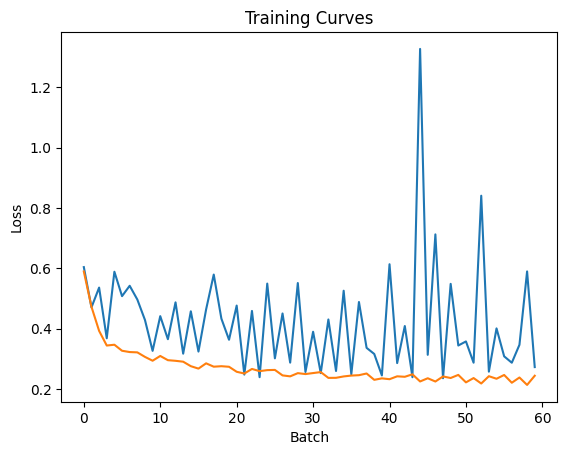

In [97]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
plt.show()

### Finding Disallowed Peptides

In [98]:
def is_disallowed(pep1, idx1, pep2, idx2, feature_fxn, sim_fxn, sim_threshold):
    if sim_fxn(feature_fxn(pep1), feature_fxn(pep2)) >= sim_threshold:
        return True
    else:
        return False

In [99]:
pairs = [(idx, idx2) for idx, pep1 in enumerate(peps) for idx2, pep2 in enumerate(peps[idx + 1:]) if is_disallowed(pep1, idx, pep2, idx2, dummy_embed, ratio_similarity, 0.6)]

In [100]:
pairs

[(0, 19), (3, 19), (44, 14), (66, 30), (90, 5)]

In [58]:
def gen_vectorization(seq, mapping_table):
    return np.stack([(mapping_table.loc[s]) for s in seq])


def dataset_mapping(dset, mapping_table):
    return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])

In [57]:
aa_prop = pd.DataFrame(map(lambda x: x.split(","),
                               ("1.29,0.9,0,0.049,1.8,0,0,0.047,0.065,0.78,67,1,0,0,1;"
                                "1.11,0.74,0,0.02,2.5,-2,0,0.015,0.015,0.8,86,1,1,-1,0;"
                                "1.04,0.72,-1,0.051,-3.5,-2,1,0.071,0.074,1.41,91,1,0,1;"
                                "1.44,0.75,-1,0.051,-3.5,-2,1,0.094,0.089,1,109,1,0,1,0;"
                                "1.07,1.32,0,0.051,2.8,0,0,0.021,0.029,0.58,135,1,1,-1,0;"
                                "0.56,0.92,0,0.06,-0.4,0,0,0.071,0.07,1.64,48,1,0,1,1;"
                                "1.22,1.08,0,0.034,-3.2,1,1,0.022,0.025,0.69,118,1,0,-1,0;"
                                "0.97,1.45,0,0.047,4.5,0,0,0.032,0.035,0.51,124,1,1,-1,0;"
                                "1.23,0.77,1,0.05,-3.9,2,1,0.105,0.08,0.96,135,1,0,1,0;"
                                "1.3,1.02,0,0.078,3.8,0,0,0.052,0.063,0.59,124,1,1,-1,1;"
                                "1.47,0.97,0,0.027,1.9,0,0,0.017,0.016,0.39,124,1,1,1,0;"
                                "0.9,0.76,0,0.058,-3.5,0,1,0.062,0.053,1.28,96,1,0,1,1;"
                                "0.52,0.64,0,0.051,-1.6,0,0,0.052,0.054,1.91,90,1,0,1,0;"
                                "1.27,0.8,0,0.051,-3.5,1,1,0.053,0.051,0.97,114,1,0,1,0;"
                                "0.96,0.99,1,0.066,-4.5,2,1,0.068,0.059,0.88,148,1,0,1,1;"
                                "0.82,0.95,0,0.057,-0.8,-1,1,0.072,0.071,1.33,73,1,0,1,1;"
                                "0.82,1.21,0,0.064,-0.7,-1,0,0.064,0.065,1.03,93,1,0,0,1;"
                                "0.91,1.49,0,0.049,4.2,0,0,0.048,0.048,0.47,105,1,1,-1,0;"
                                "0.99,1.14,0,0.022,-0.9,1,1,0.007,0.012,0.75,163,1,1,-1,0;"
                                "0.72,1.25,0,0.07,-1.3,-1,1,0.032,0.033,1.05,141,1,1,-1,1").split(";")),
                           columns=['alpha', 'beta', 'charge', 'core', 'hydropathy', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'strength', 'disorder', 'high_contact', 'count'],
                           index=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

aa_prop = aa_prop.astype(float)
aa_prop

,alpha,beta,charge,core,hydropathy,pH,polarity,rim,surface,turn,volume,strength,disorder,high_contact,count
A,1.29,0.90,0.0,0.049,1.8,0.0,0.0,0.047,0.065,0.78,67.0,1.0,0.0,0.0,1.0
C,1.11,0.74,0.0,0.020,2.5,-2.0,0.0,0.015,0.015,0.80,86.0,1.0,1.0,-1.0,0.0
D,1.04,0.72,-1.0,0.051,-3.5,-2.0,1.0,0.071,0.074,1.41,91.0,1.0,0.0,1.0,NaN
E,1.44,0.75,-1.0,0.051,-3.5,-2.0,1.0,0.094,0.089,1.00,109.0,1.0,0.0,1.0,0.0
F,1.07,1.32,0.0,0.051,2.8,0.0,0.0,0.021,0.029,0.58,135.0,1.0,1.0,-1.0,0.0
G,0.56,0.92,0.0,0.060,-0.4,0.0,0.0,0.071,0.070,1.64,48.0,1.0,0.0,1.0,1.0
H,1.22,1.08,0.0,0.034,-3.2,1.0,1.0,0.022,0.025,0.69,118.0,1.0,0.0,-1.0,0.0
I,0.97,1.45,0.0,0.047,4.5,0.0,0.0,0.032,0.035,0.51,124.0,1.0,1.0,-1.0,0.0
K,1.23,0.77,1.0,0.050,-3.9,2.0,1.0,0.105,0.080,0.96,135.0,1.0,0.0,1.0,0.0
L,1.30,1.02,0.0,0.078,3.8,0.0,0.0,0.052,0.063,0.59,124.0,1.0,1.0,-1.0,1.0


In [59]:
dataset_mapping(random.sample(list(np.unique(vdjdb['Epitope'])), 100), aa_prop)

/tmp/ipykernel_1128390/3868959576.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])


array([array([[ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 5.20e-01,  6.40e-01,  0.00e+00,  5.10e-02, -1.60e+00,  0.00e+00,
                0.00e+00,  5.20e-02,  5.40e-02,  1.91e+00,  9.00e+01,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 1.27e+00,  8.00e-01,  0.00e+00,  5.10e-02, -3.50e+00,  1.00e+00,
                1.00e+00,  5.30e-02,  5.10e-02,  9.70e-01,  1.14e+02,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 1.29e+00,  9.00e-01,  0.00e+00,  4.90e-02,  1.80e+00,  0.00e+00,
                0.00e+00,  4.70e-02,  6.50e-02,  7.80e-01,  6.70e+01,  1.00

## Graveyard

In [13]:

from transformers.pipelines import FeatureExtractionPipeline, AggregationStrategy

class PeptideExtractionPipeline(FeatureExtractionPipeline):
    def __init__(self, model, tokenizer, *args, **kwargs):
        super().__init__(
            model,
            tokenizer,
            *args,
            **kwargs
        )

    def _forward(self, model_inputs):
        model_inputs = self.ensure_tensor_on_device(**model_inputs)
        outputs = self.model(**model_inputs)
        logits = outputs.logits
        hidden_state = outputs.hidden_states[-1]

        return {
            "logits": logits,
            "hidden_state": hidden_state,  # Add hidden state to the returned dictionary
        }

    def postprocess(self, model_outputs):
        return model_outputs["hidden_state"]

2023-06-14 20:04:37.250602: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-14 20:04:37.380912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
pipe = PeptideExtractionPipeline(model=_ESM2_MODEL, tokenizer=_ESM2_TOKENIZER, batch_size=1, device='cpu')
pipe('AVFDRKSDAK').shape

torch.Size([1, 12, 320])

In [24]:
predictions = [pipe(epi) for epi in data_df2['Epitope'].values]



In [15]:
pipe.device

device(type='cpu')

In [23]:
import psutil
import ray

num_cpus = psutil.cpu_count(logical=True)
print('Number of available CPUs:', num_cpus)

# Start Ray cluster
ray.init(num_cpus=num_cpus-4, ignore_reinit_error=True)

"""
The command ray.put(x) would be run by a worker process or by the driver process (the driver process is the one running your script). 
It takes a Python object and copies it to the local object store (here local means on the same node). 
Once the object has been stored in the object store, its value cannot be changed.
In addition, ray.put(x) returns an object ID, which is essentially an ID that can be used to refer to the newly created remote object. 
If we save the object ID in a variable with x_id = ray.put(x), 
then we can pass x_id into remote functions, 
and those remote functions will operate on the corresponding remote object.
"""
pipe_id = ray.put(pipe)

# @ray.remote decorator enables to use this 
# function in distributed setting
@ray.remote
def predict(pipeline, inp):
    return pipeline(inp)


# Run the function using multiple cores and gather the results

predictions = ray.get([predict.remote(pipe_id, epi) for epi in data_df2['Epitope'].values])

# Stop running Ray cluster
ray.shutdown()


Number of available CPUs: 20


2023-06-14 20:07:56,907	INFO worker.py:1636 -- Started a local Ray instance.


In [22]:
predictions[].shape

torch.Size([1, 12, 320])

In [41]:
inps = _ESM2_TOKENIZER("CASSLARDIPRDF", padding=True, truncation=True, max_length=15, return_tensors='pt')
with torch.no_grad():
    print(_ESM2_MODEL(**inps).hidden_states[-1].shape)

torch.Size([1, 15, 320])
